In [ ]:
#IMPORT LIBRARIES
from os.path import join
import shutil
import glob
import sys
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [1]:
import cv2
import os
import itertools
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
import imageio
from skimage.transform import resize
import re
import itertools
from skimage.transform import resize
from skimage.morphology import label
from tqdm import tqdm
import random
from skimage.color import rgb2gray
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Add, Flatten, Conv2D, MaxPooling2D, AveragePooling2D, BatchNormalization,Conv2D, UpSampling2D, Lambda, ZeroPadding2D
from keras.models import Model, load_model
from keras.layers import Input, SpatialDropout2D, SeparableConv2D, LocallyConnected2D
from keras.layers.core import Dropout, Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint, TensorBoard
from keras import initializers, layers, models
from keras.preprocessing.image import ImageDataGenerator
from keras import callbacks
from keras import optimizers
from keras import regularizers
from keras.losses import mse

from keras import callbacks
from scipy import ndimage

from keras import optimizers
import skimage
from pathlib import Path
from subprocess import check_output

import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1 import make_axes_locatable

from UnetUtils import *

/home/roberto/anaconda3/envs/tf_1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/roberto/anaconda3/envs/tf_1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/roberto/anaconda3/envs/tf_1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/roberto/anaconda3/envs/tf_1.12/lib

In [4]:
IMG_WIDTH = 1600
IMG_HEIGHT = 1200

width_crop = 512
height_crop = 512

ALL_IMAGES = Path('./DATASET/TEST/images/')
ALL_MASKS = Path('./DATASET/TEST/masks/')

test_ids = check_output(["ls", str(ALL_IMAGES) + '/']).decode("utf8").split()

TotTestSamples = len(check_output(["ls",str(ALL_IMAGES) + '/']).decode("utf8").split())

In [5]:
def create_weighted_binary_crossentropy_2(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):
        
        # Original binary crossentropy (see losses.py):
        # K.mean(K.binary_crossentropy(y_true, y_pred), axis=-1)

        # Calculate the binary crossentropy
        b_ce = K.binary_crossentropy(y_true[:,:,:,0:1], y_pred[:,:,:,0:1])
    

        # Apply the weights
        weight_vector0 = y_true[:,:,:,0:1] * one_weight + (1. - y_true[:,:,:,0:1]) * zero_weight

        weight_vector = weight_vector0 * y_true[:,:,:,1:2]*3.8177538
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

def create_weighted_binary_crossentropy(zero_weight, one_weight):

    def weighted_binary_crossentropy(y_true, y_pred):

        b_ce = K.binary_crossentropy(y_true[:,:,:,0:1], y_pred[:,:,:,0:1])

        # Apply the weights
        weight_vector = y_true[:,:,:,0:1] * one_weight + (1. - y_true[:,:,:,0:1]) * zero_weight
        weighted_b_ce = weight_vector * b_ce

        # Return the mean error
        return K.mean(weighted_b_ce)

    return weighted_binary_crossentropy

In [6]:
WeightedLoss = create_weighted_binary_crossentropy(1, 1.5)
MapWeightedLoss = create_weighted_binary_crossentropy_2(1, 1.5)
LossHalved = create_weighted_binary_crossentropy(1, 1.5)

In [7]:
def mean_iou(y_true, y_pred):
    prec = []
    for t in np.arange(0.5, 1.0, 0.05):
        y_pred_ = tf.to_int32(y_pred[:,:,:,0:1] > t)
        score, up_opt = tf.metrics.mean_iou(y_true[:,:,:,0:1], y_pred_, 2)
        K.get_session().run(tf.local_variables_initializer())
        with tf.control_dependencies([up_opt]):
            score = tf.identity(score)
        prec.append(score)
    return K.mean(K.stack(prec), axis=0)

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true[:,:,:,0:1])
    y_pred_f = K.flatten(y_pred[:,:,:,0:1])
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true[:,:,:,0:1], y_pred[:,:,:,0:1])

In [19]:
# standardizer = load_model('model_results/standardizer_2.h5')

In [20]:
# model = load_model('model_results/ResUnetStandardized.h5', custom_objects={'mean_iou': mean_iou, 'dice_coef': 
#                                                                 dice_coef, 'weighted_binary_crossentropy': WeightedLoss})

In [8]:
model = load_model('model_results/ResUnet3LossConstr.h5', custom_objects={'mean_iou': mean_iou, 'dice_coef': 
                                                dice_coef, 'weighted_binary_crossentropy': WeightedLoss,
                                                      'weighted_binary_crossentropy_2': MapWeightedLoss})

In [9]:
test_ids = check_output(["ls", str(ALL_IMAGES) + '/']).decode("utf8").split()

#sort in numeric order
NumberTest = [int(num.split('.')[0]) for num in test_ids]
NumberTest.sort()

In [10]:
start=None
end=None
Original, Target = reader(ALL_IMAGES, ALL_MASKS, NumberTest[start:end], mode='RGB'
                         ,height_crop = 1200, width_crop = 1600)

100%|██████████| 60/60 [00:32<00:00,  1.86it/s]


In [11]:
Original_scaled = Original *1./255

In [48]:
# standardized = standardizer.predict(Original_scaled, verbose=1, batch_size = 1)

60/60 [==============================] - 16s 261ms/step


In [12]:
preds_map = model.predict(Original_scaled, verbose=1, batch_size = 1)
# preds_map_stand = model.predict(standardized, verbose=1, batch_size = 1)

60/60 [==============================] - 27s 455ms/step


In [36]:
# Predicted = (preds_map > 0.55).astype(np.uint8)

In [13]:
Predicted_ref = (preds_map[2] > 0.85).astype(np.uint8)
Predicted = (preds_map[1] > 0.85).astype(np.uint8)
Predicted_halved = (preds_map[0] > 0.85).astype(np.uint8)
# Predicted_standardized = (preds_map_stand > 0.55).astype(np.uint8)

In [19]:
# for i in range(len(Original)):

#     original = Original[i]
#     standard = standardized[i]
    
#     plt.figure(figsize=(18,6))
    
#     plt.subplot(1,2,1)
#     plt.title("Original")
#     plt.axis('off')
#     plt.imshow(original)
    
#     plt.subplot(1,2,2)
#     plt.title("Predict")
#     plt.axis('off')
#     plt.imshow(standard)
    
    
#     plt.show()

In [33]:
heat_map.shape

(1200, 1600, 1)

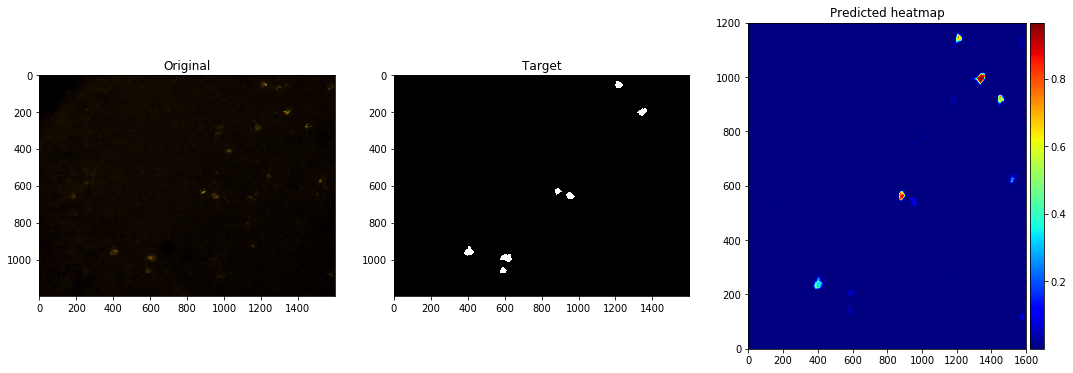

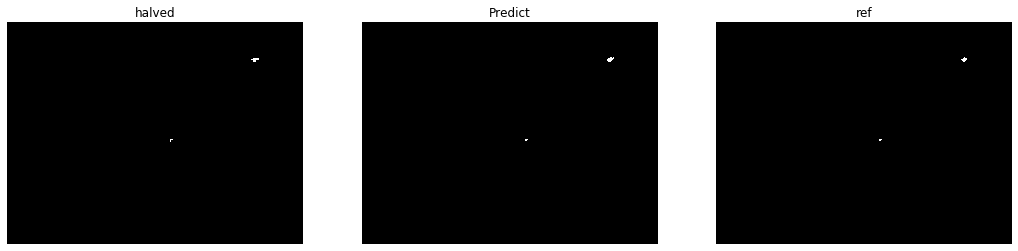

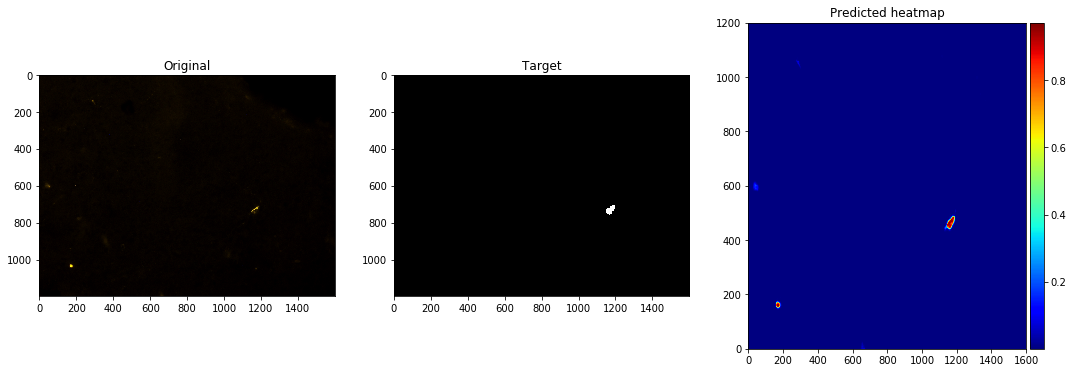

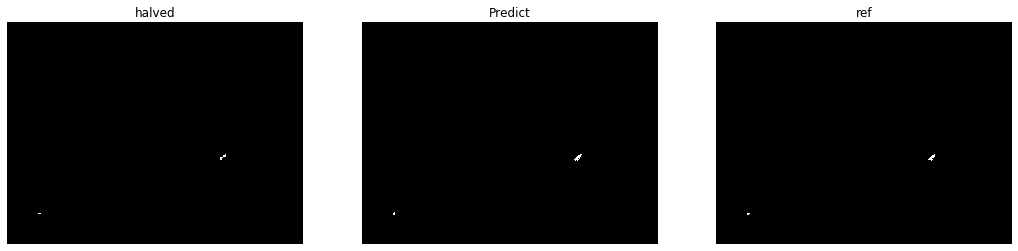

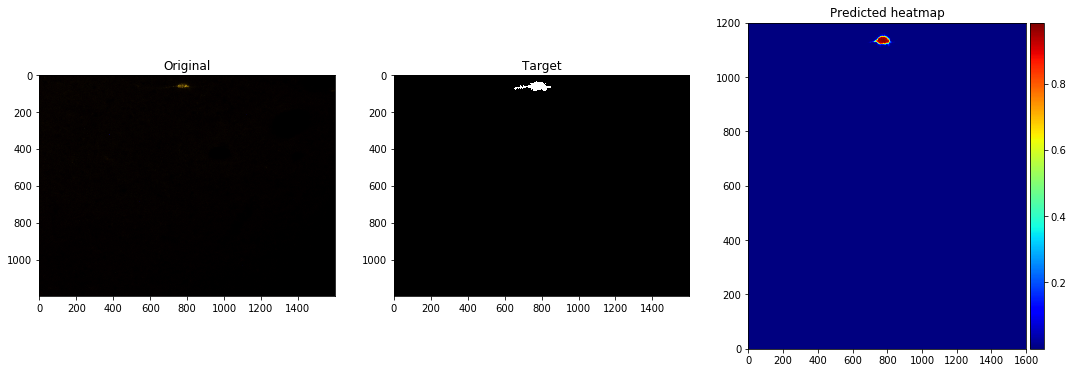

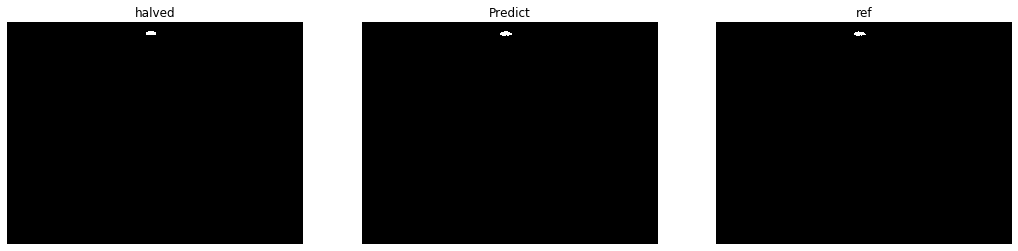

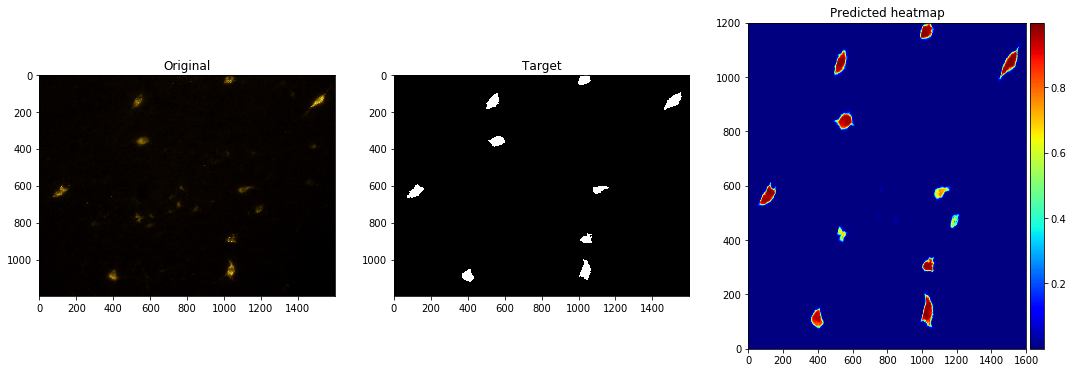

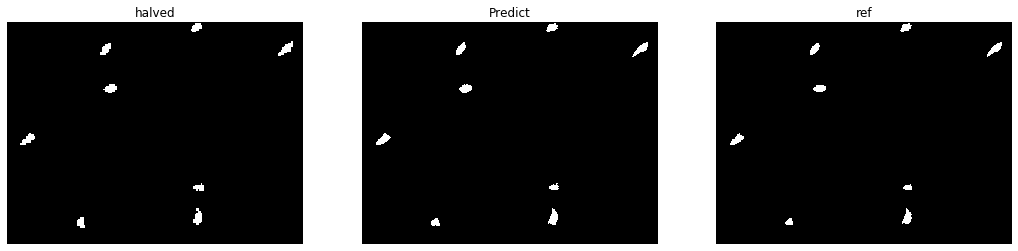

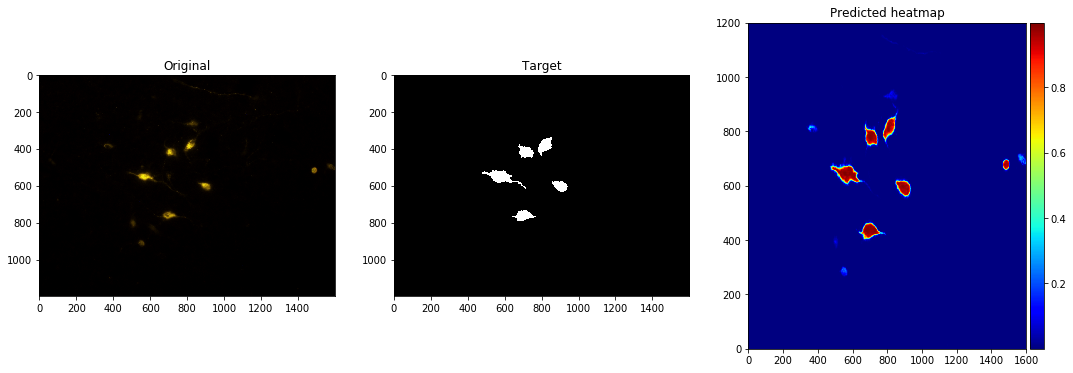

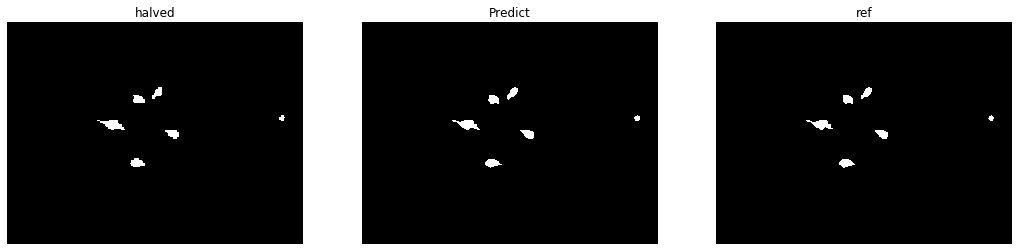

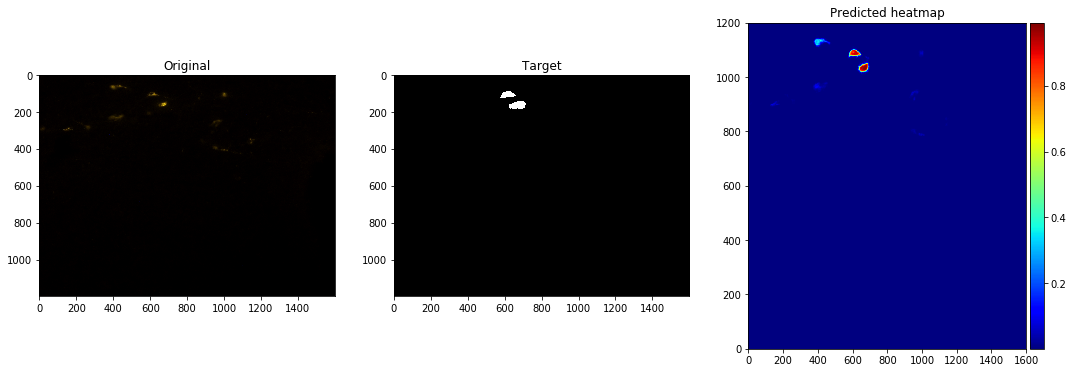

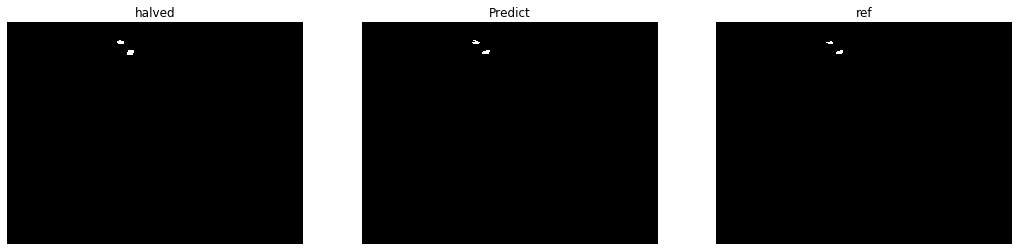

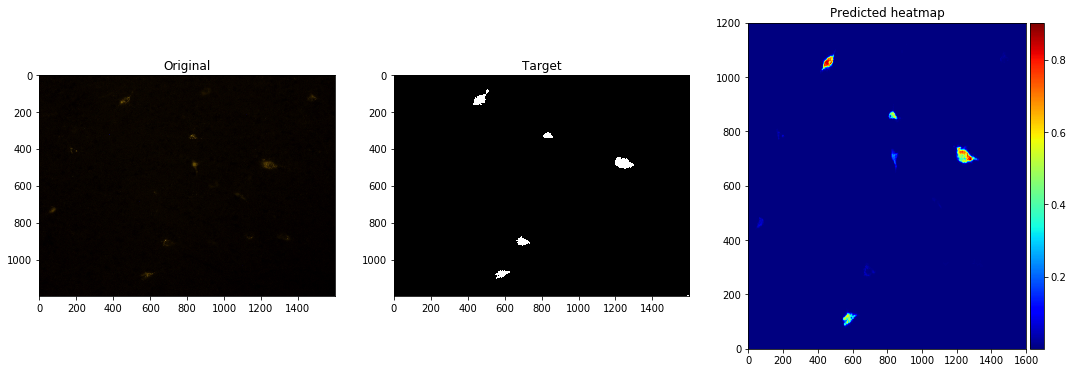

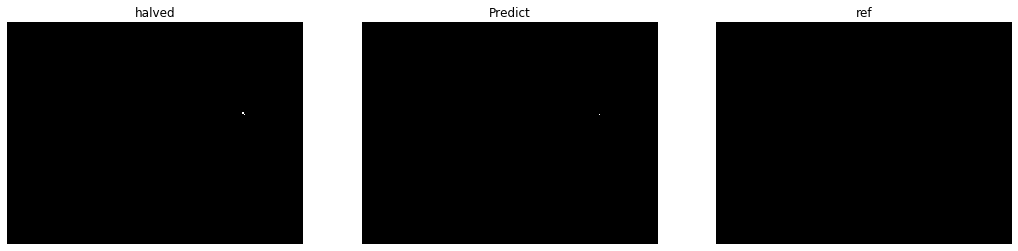

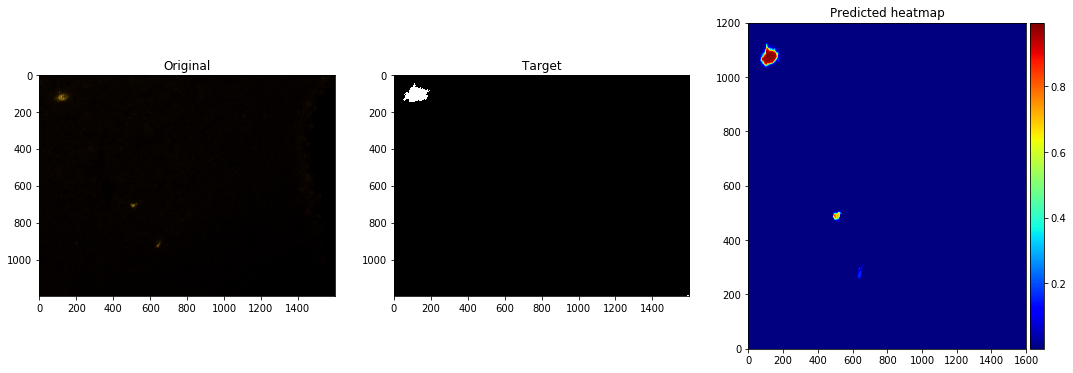

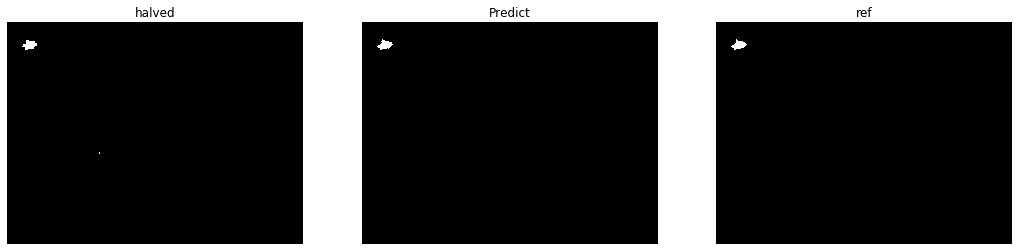

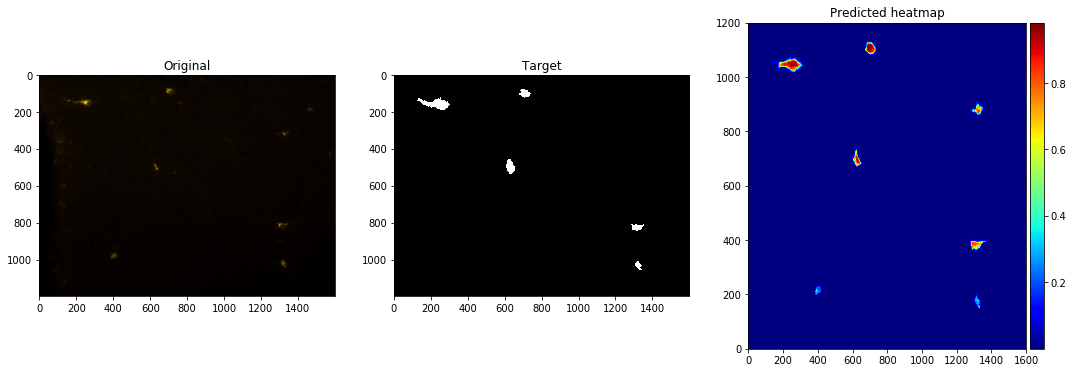

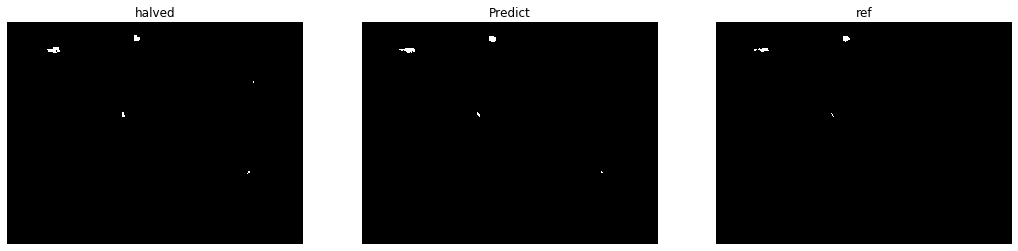

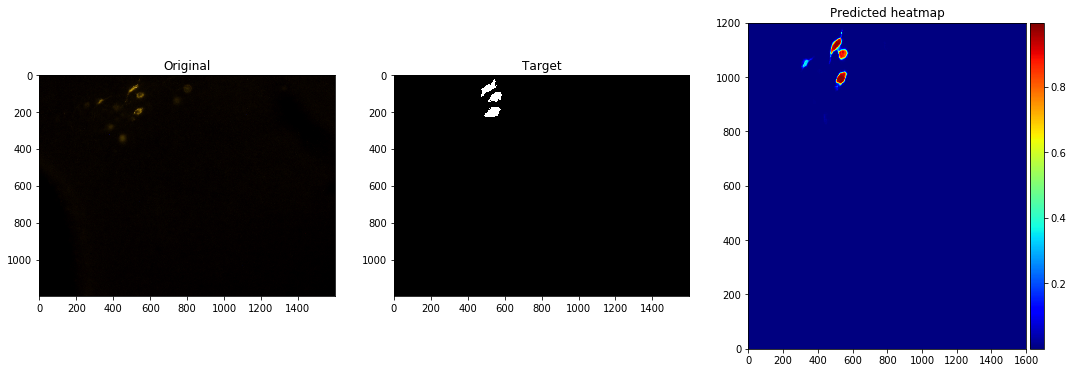

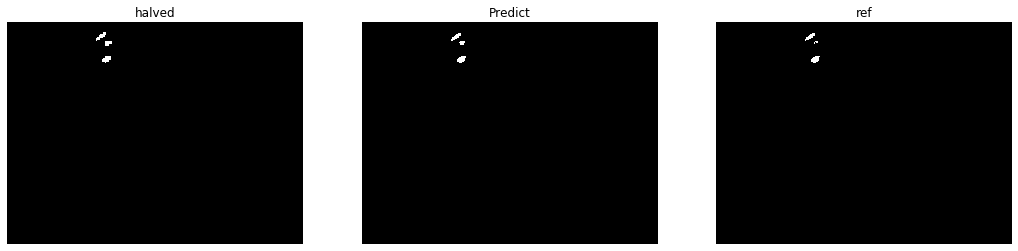

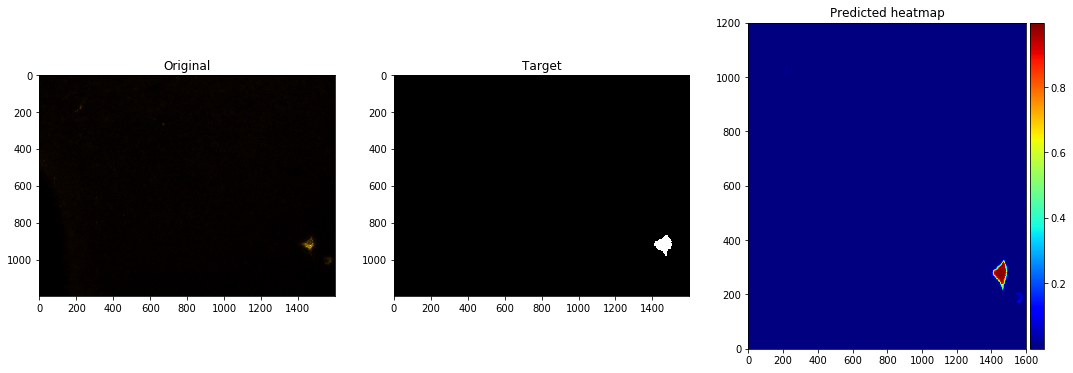

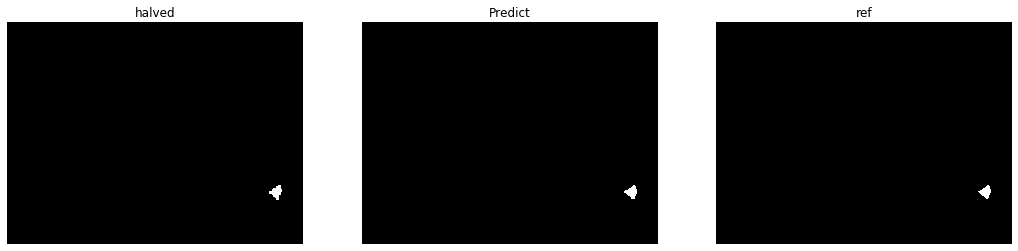

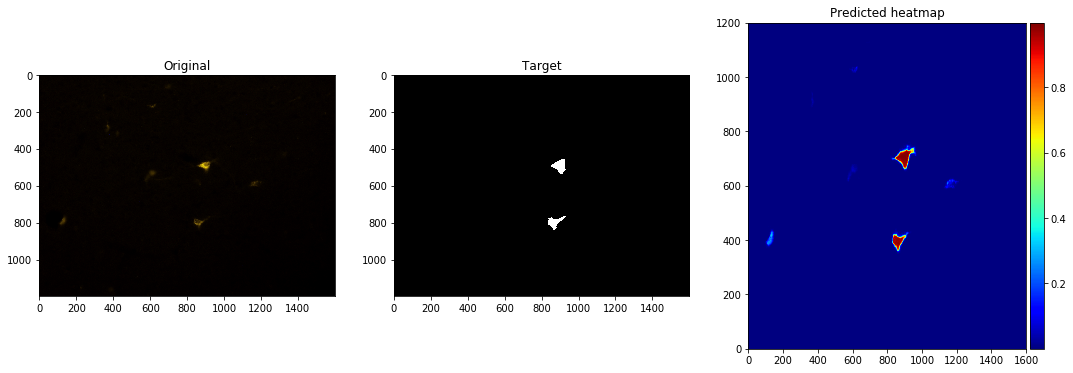

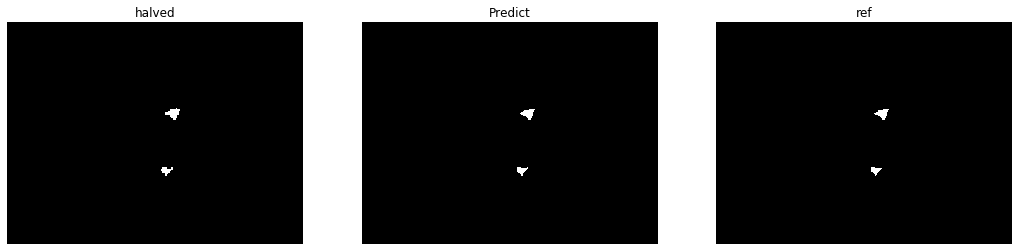

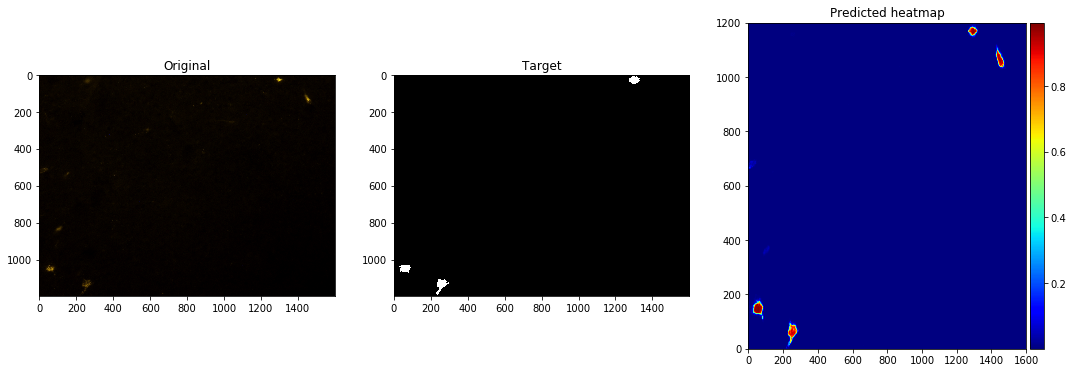

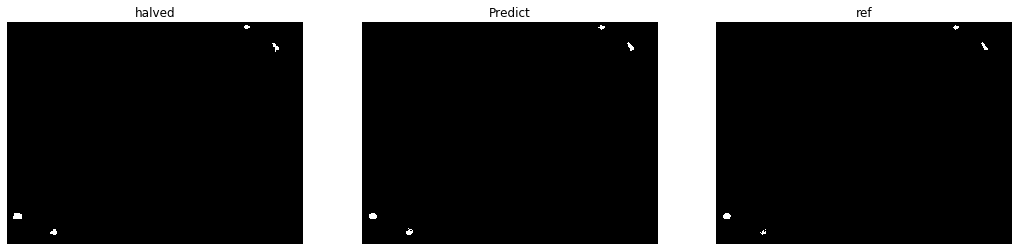

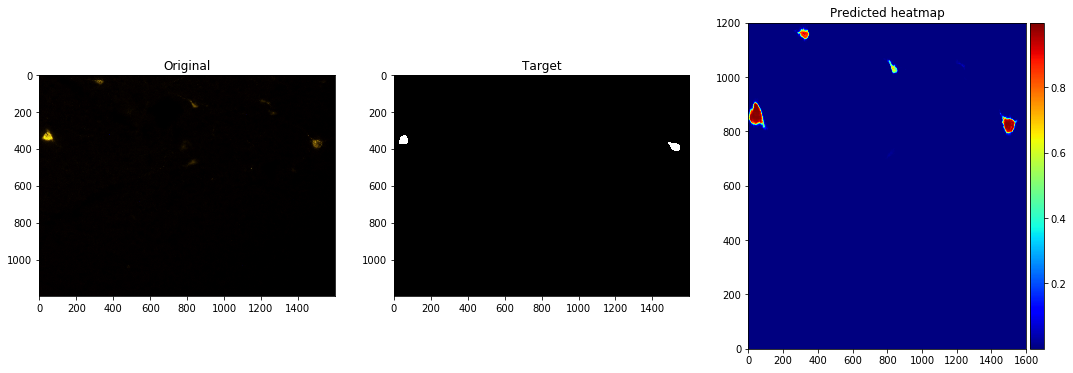

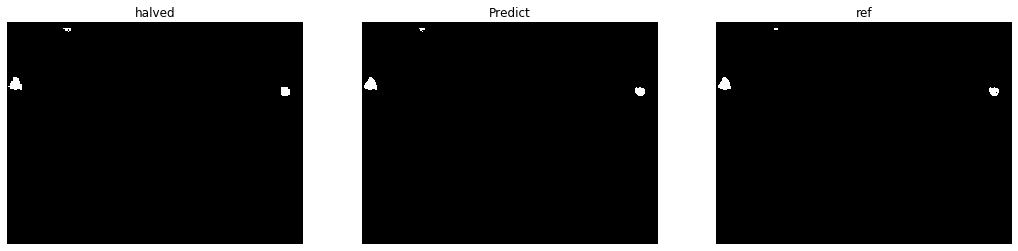

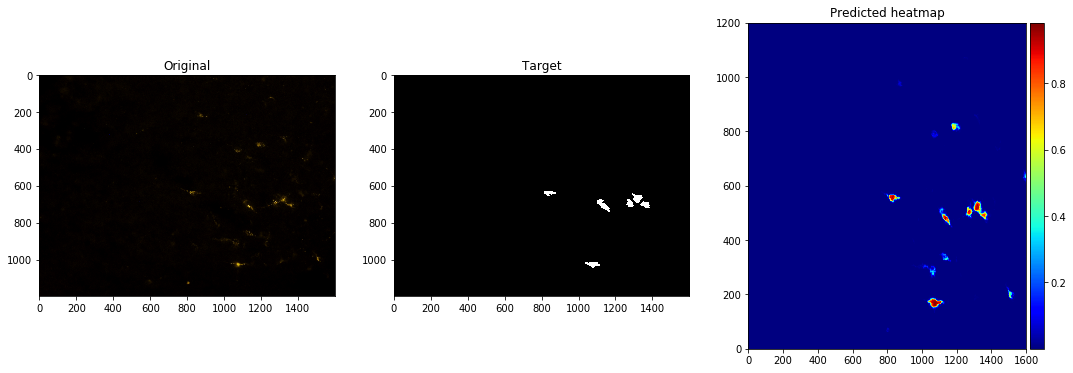

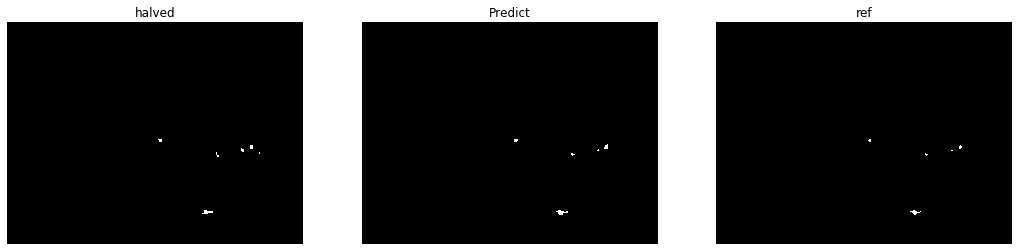

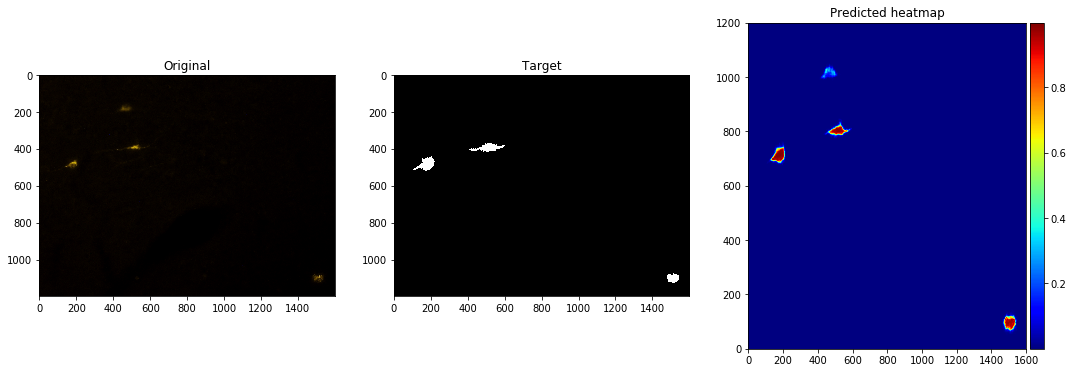

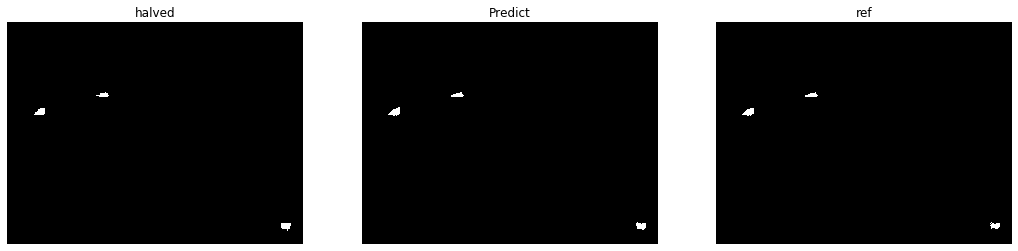

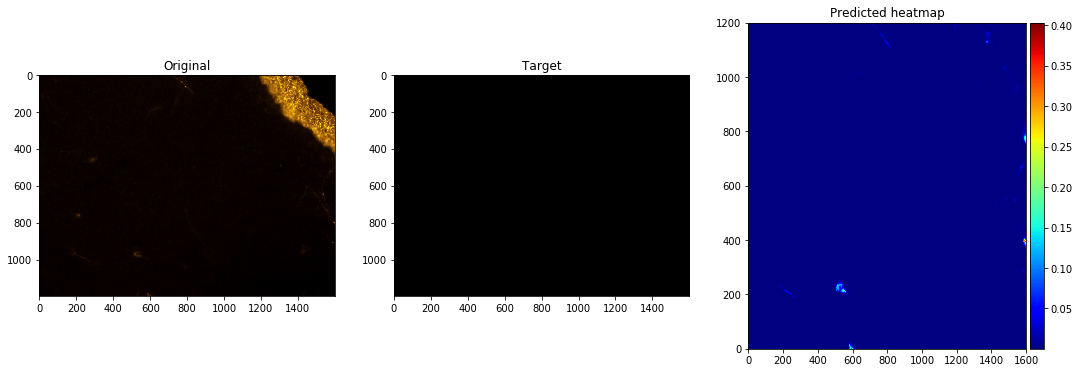

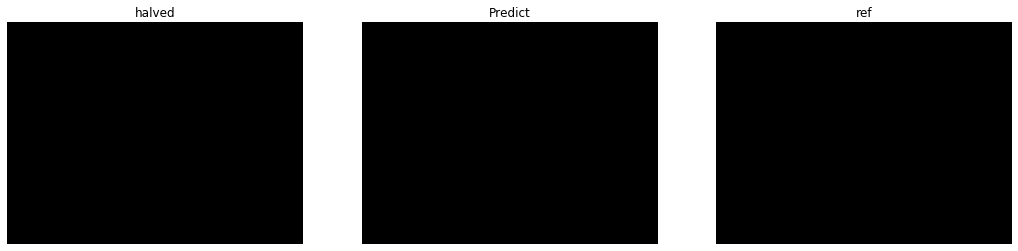

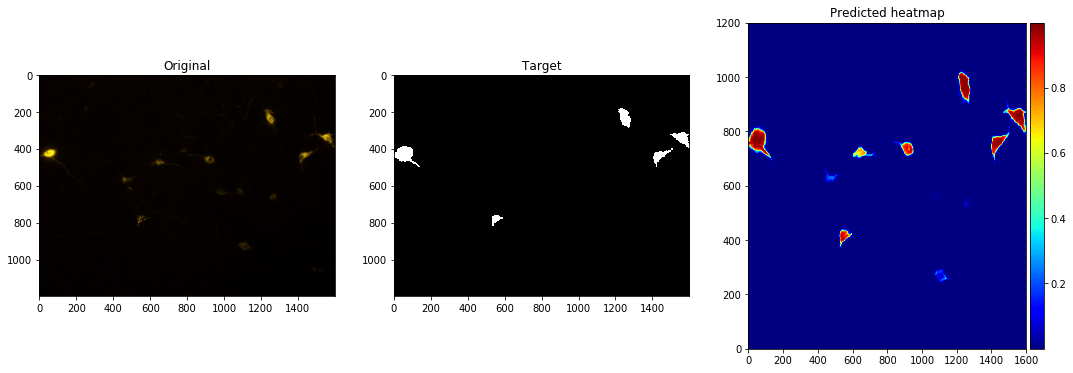

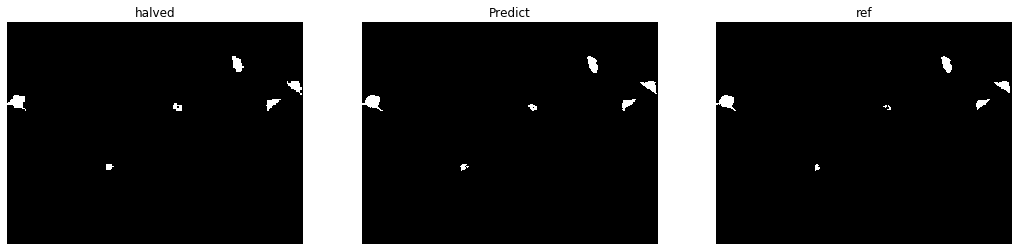

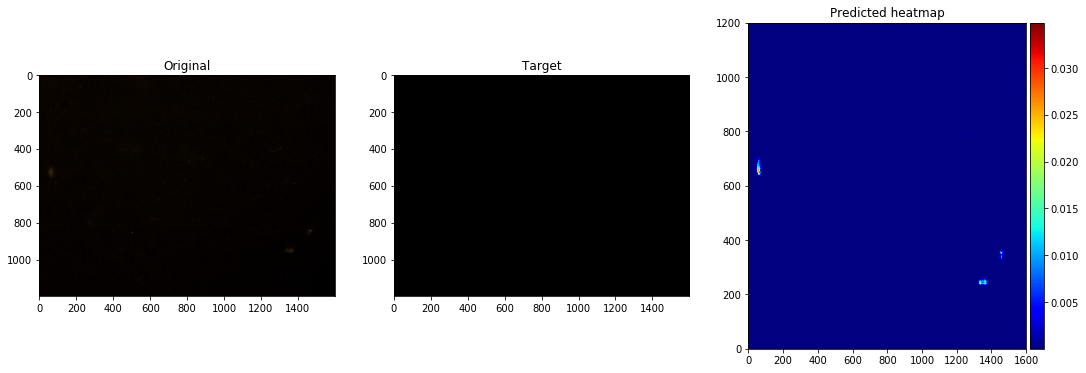

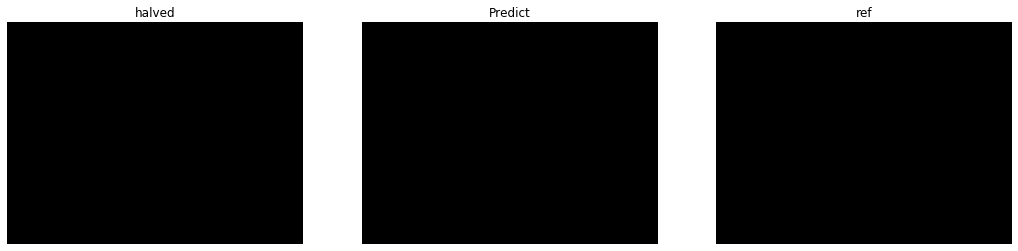

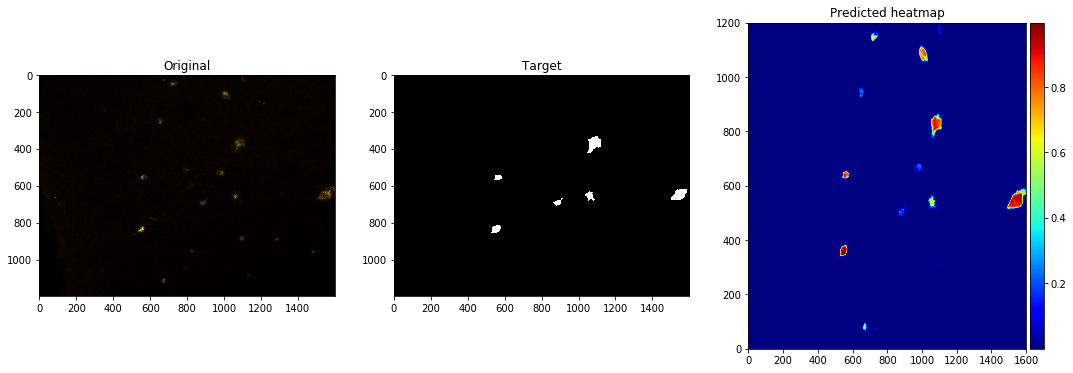

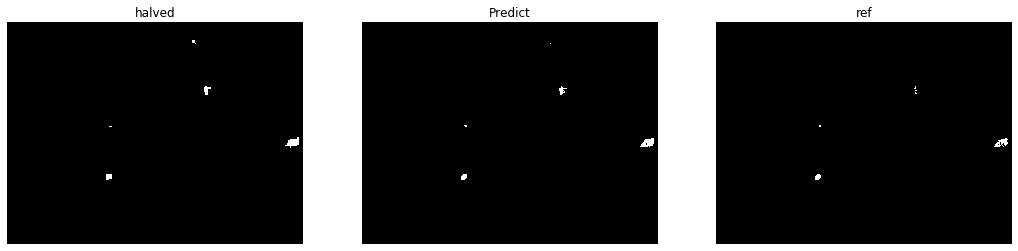

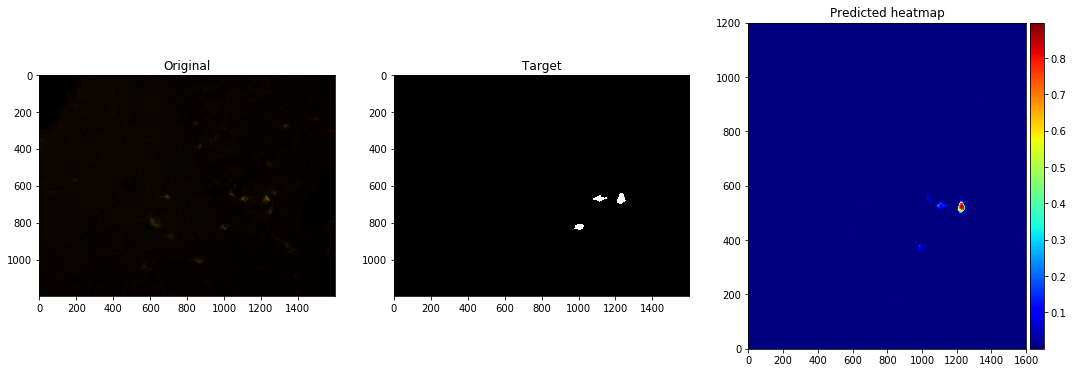

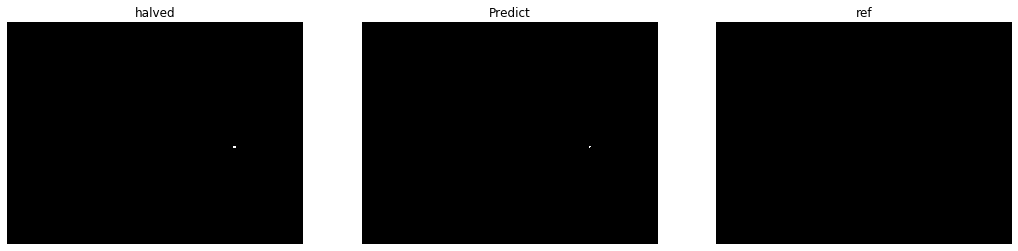

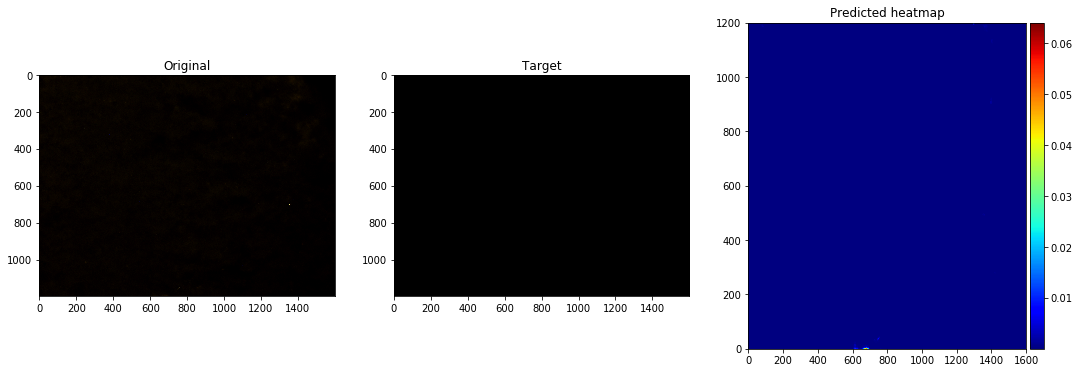

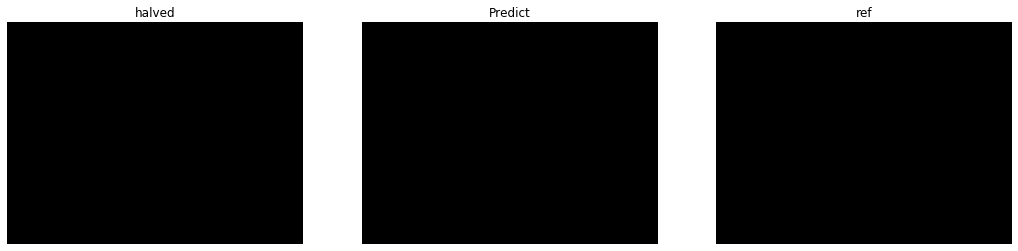

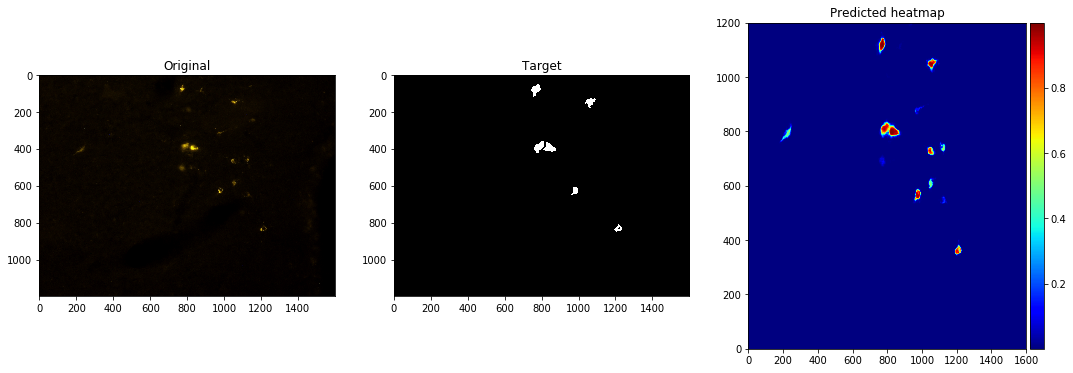

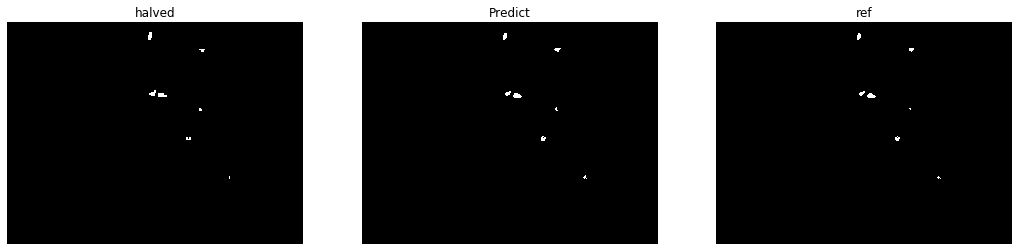

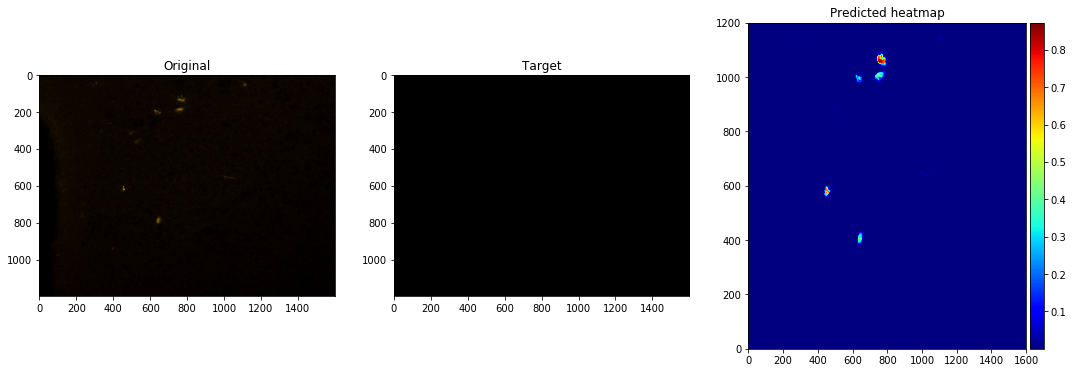

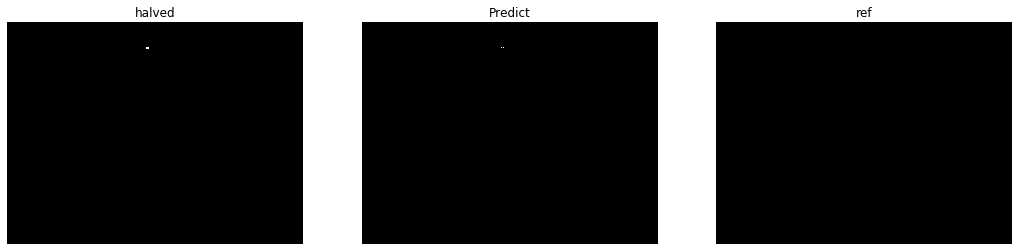

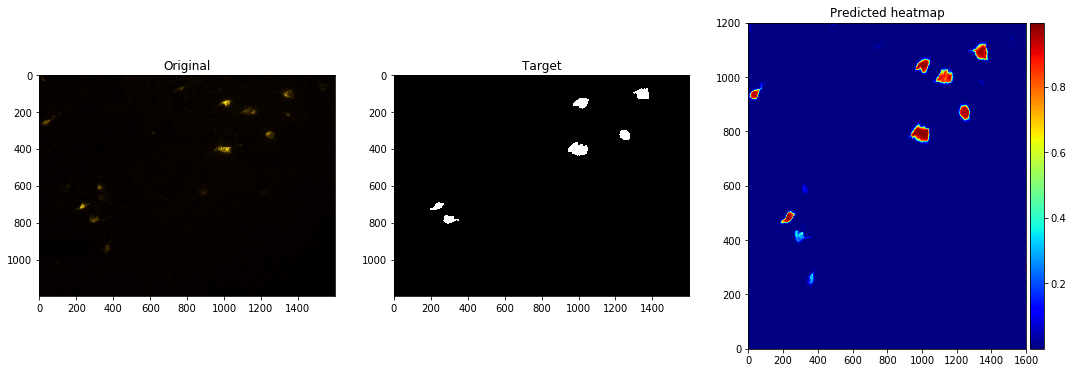

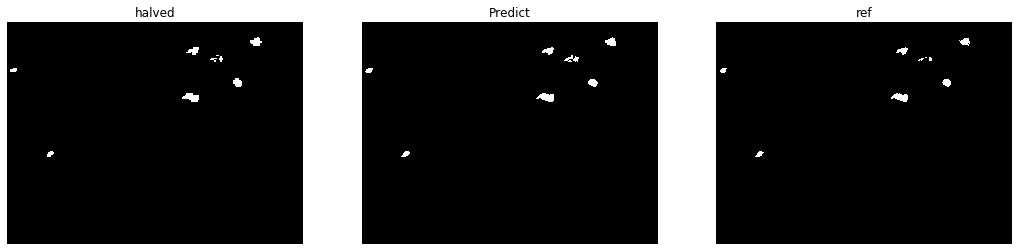

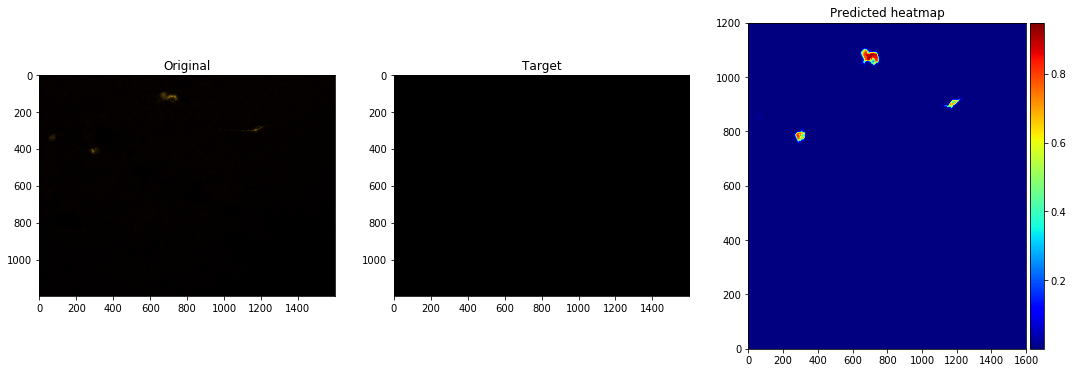

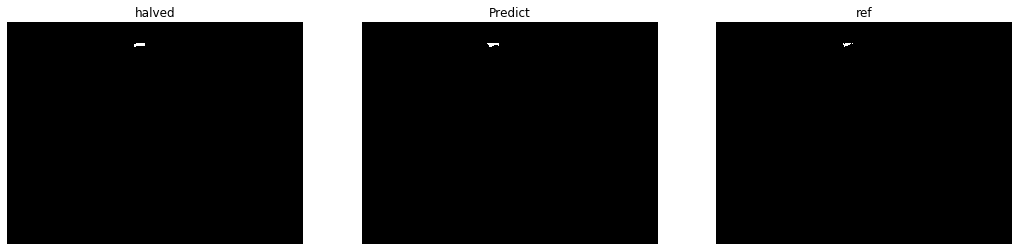

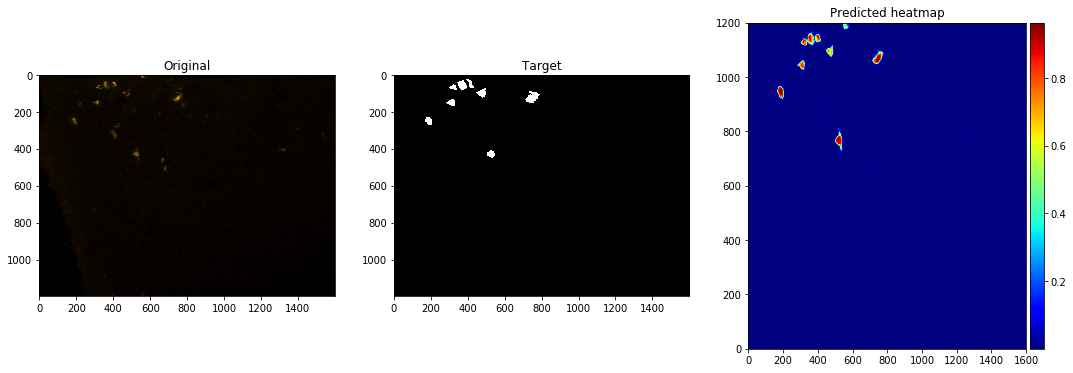

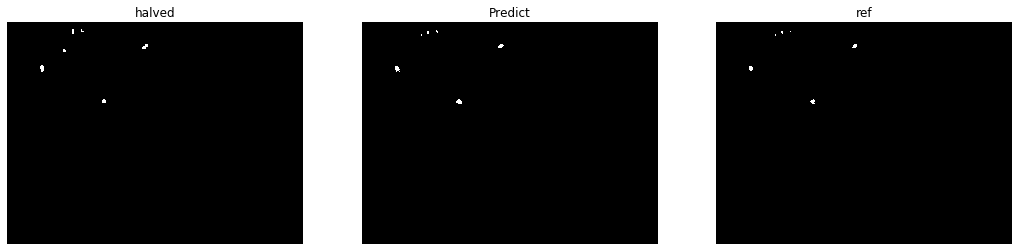

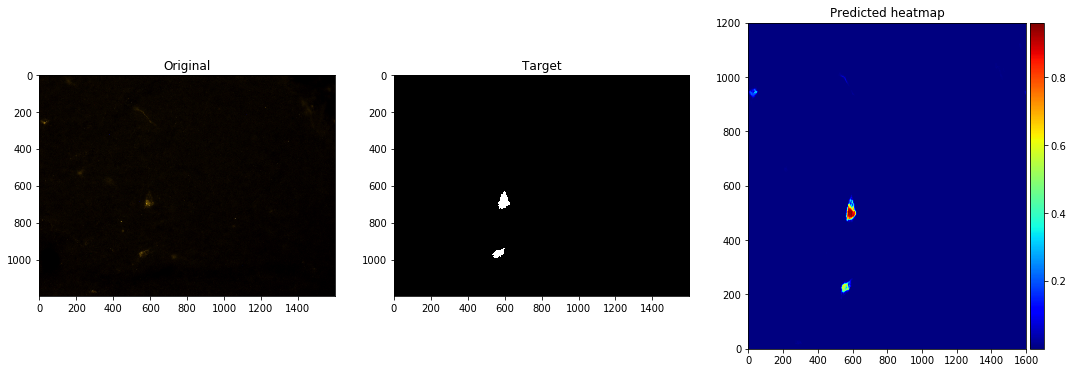

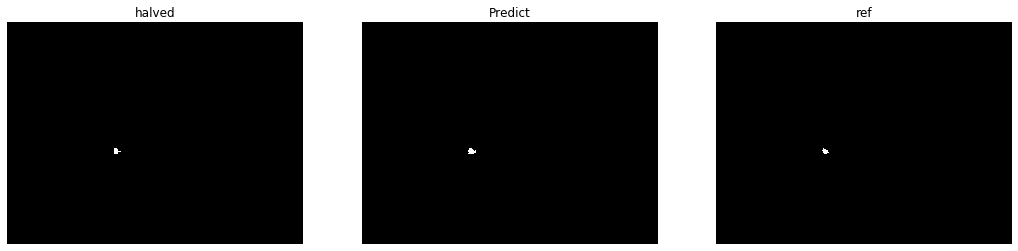

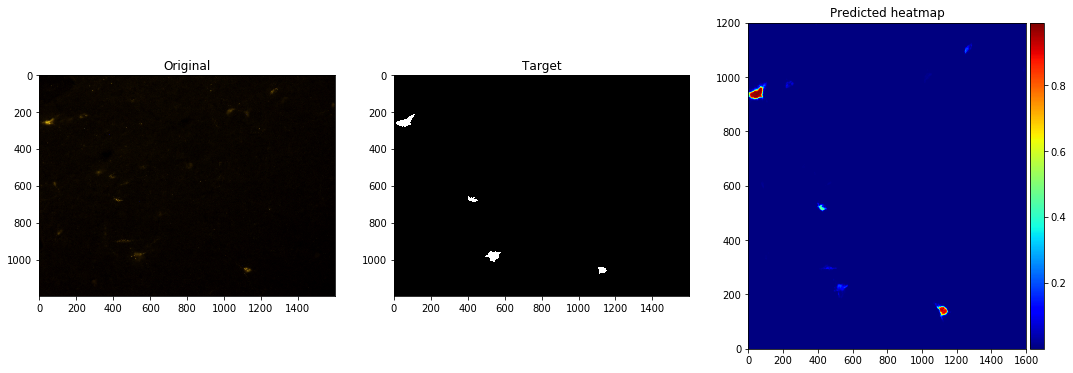

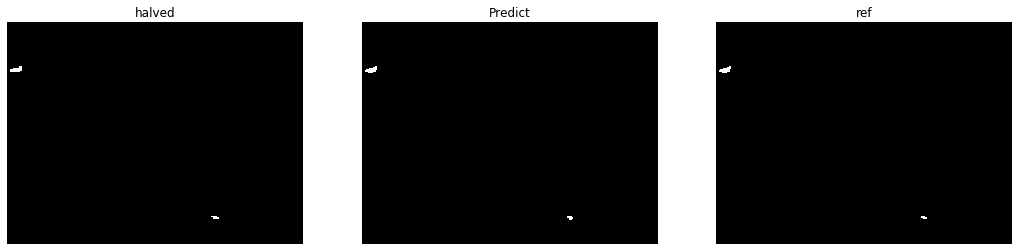

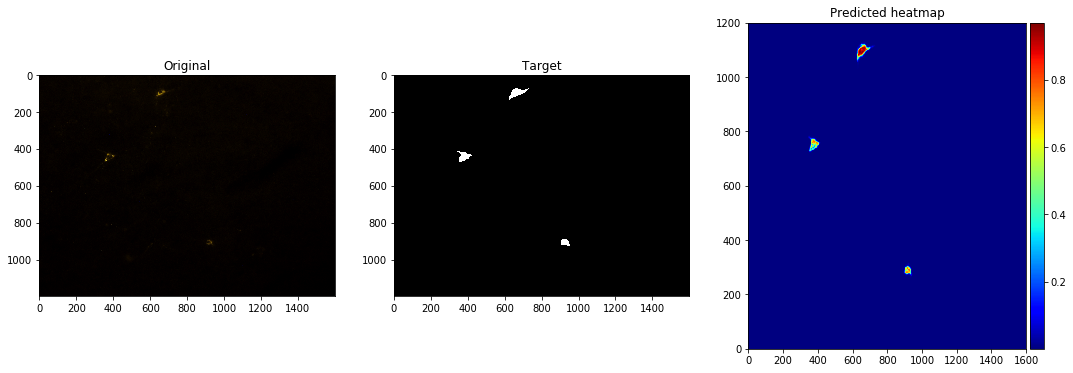

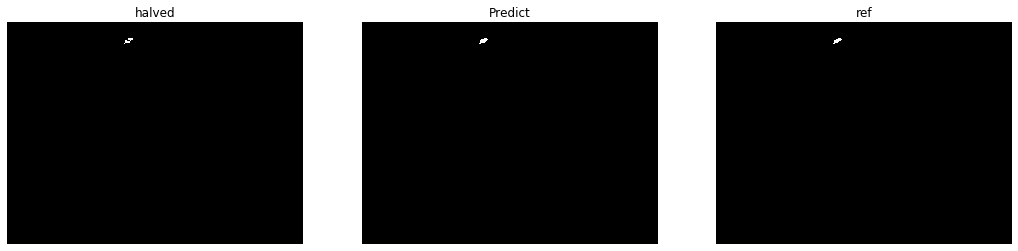

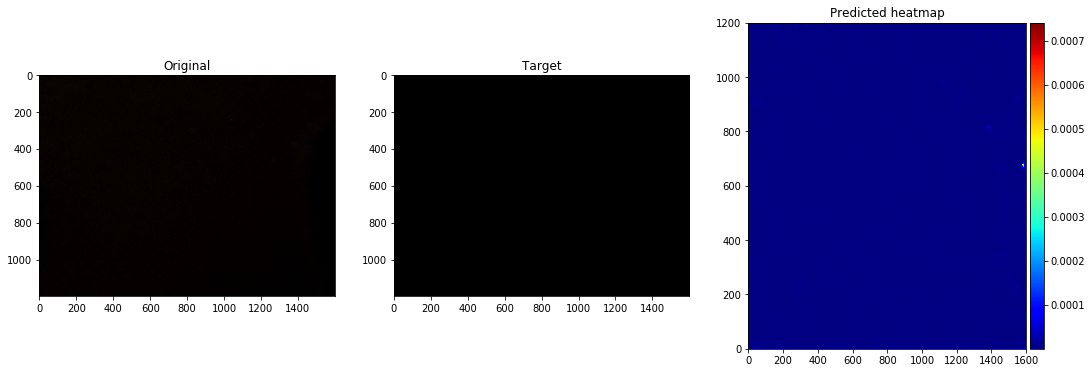

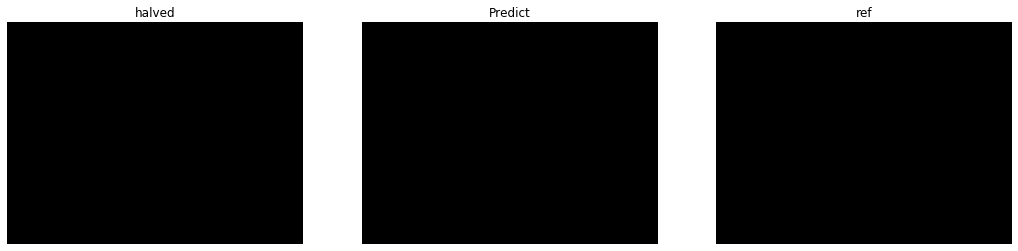

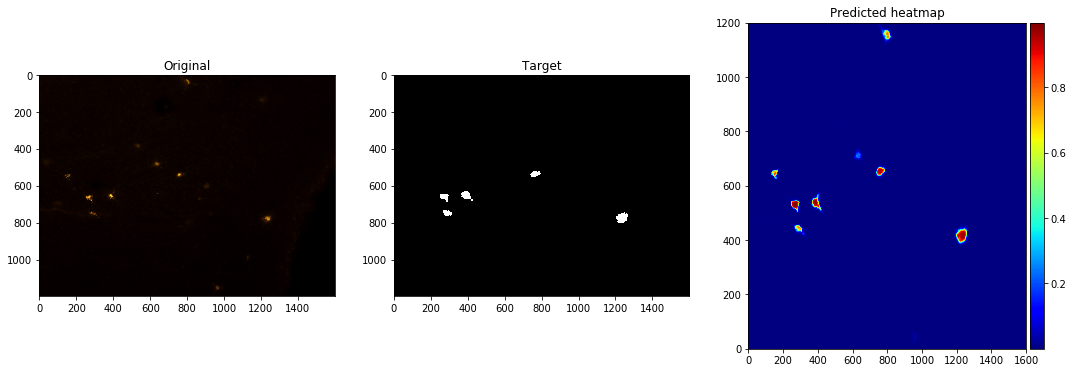

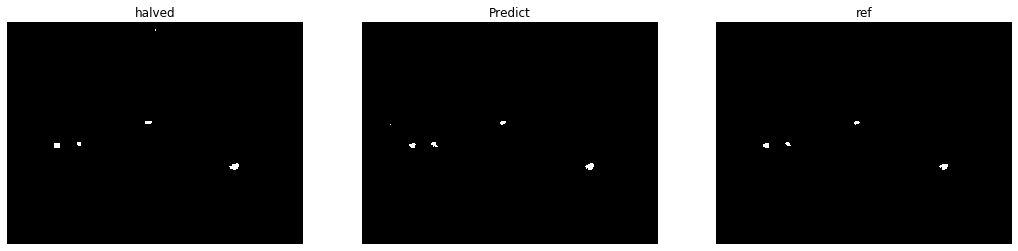

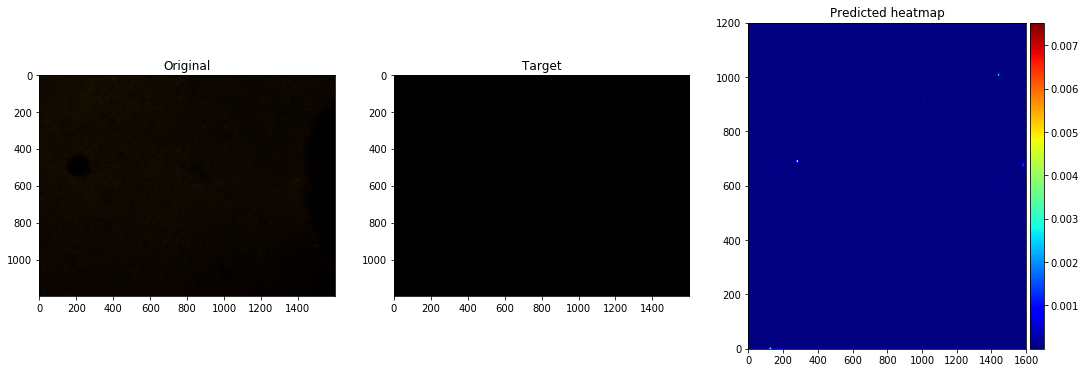

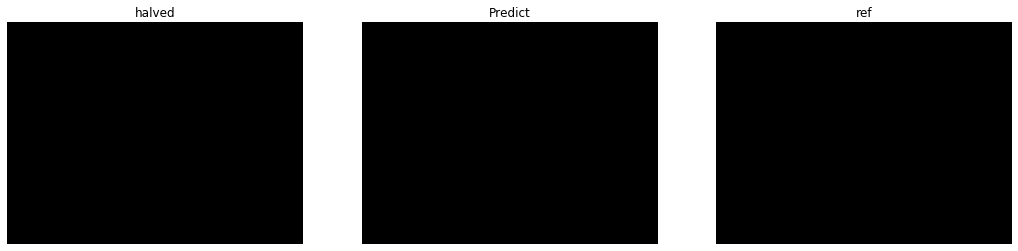

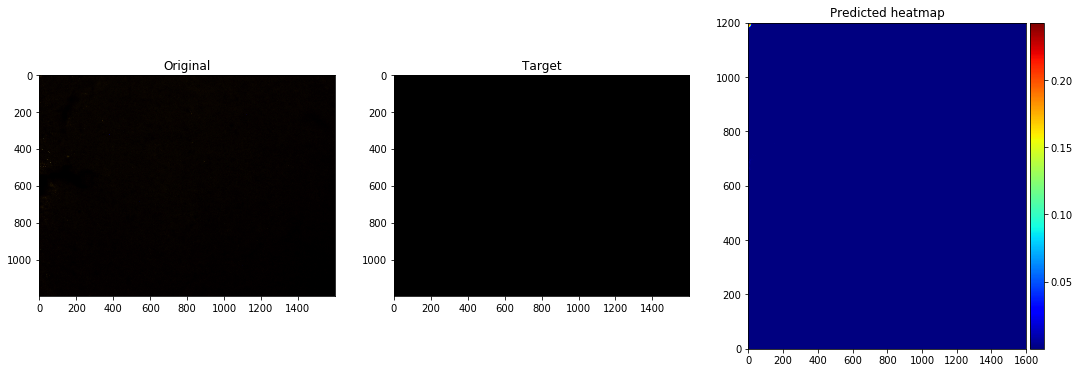

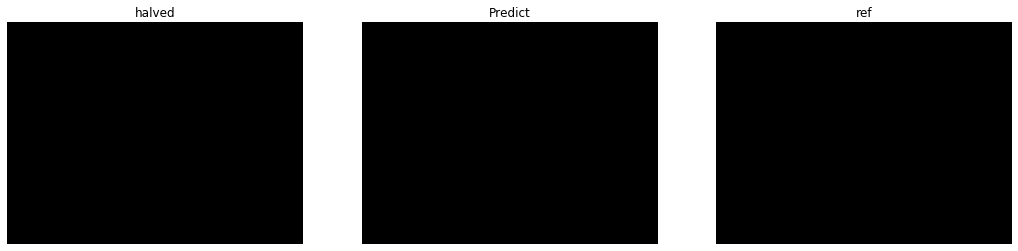

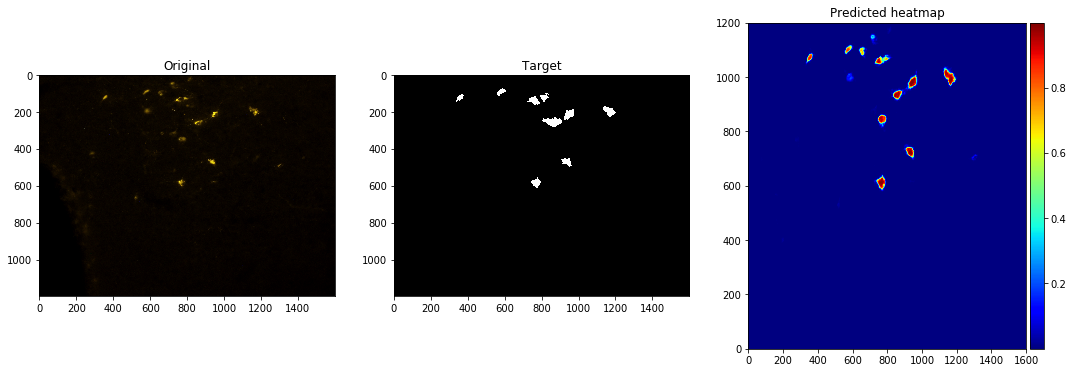

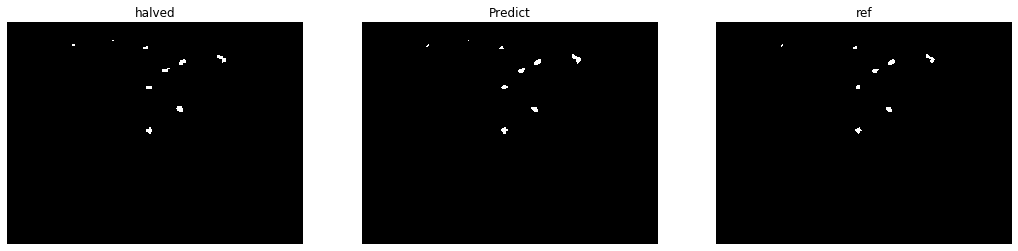

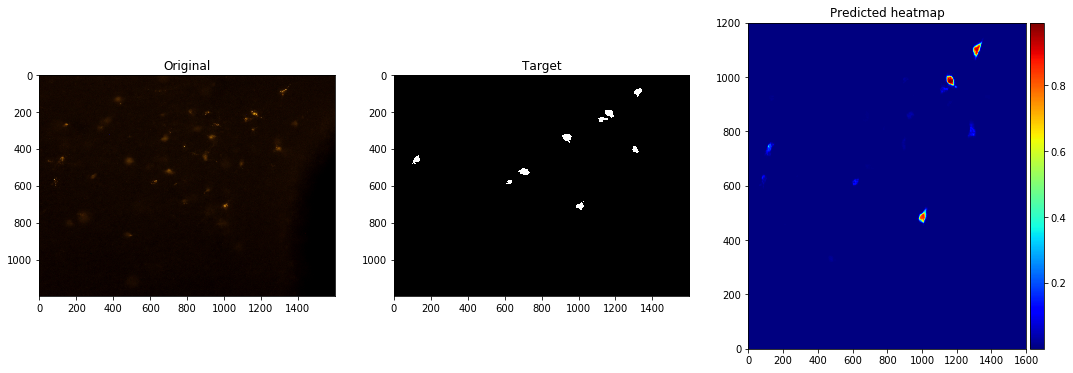

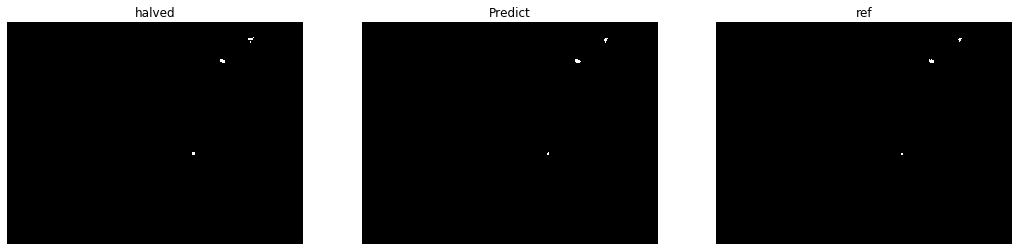

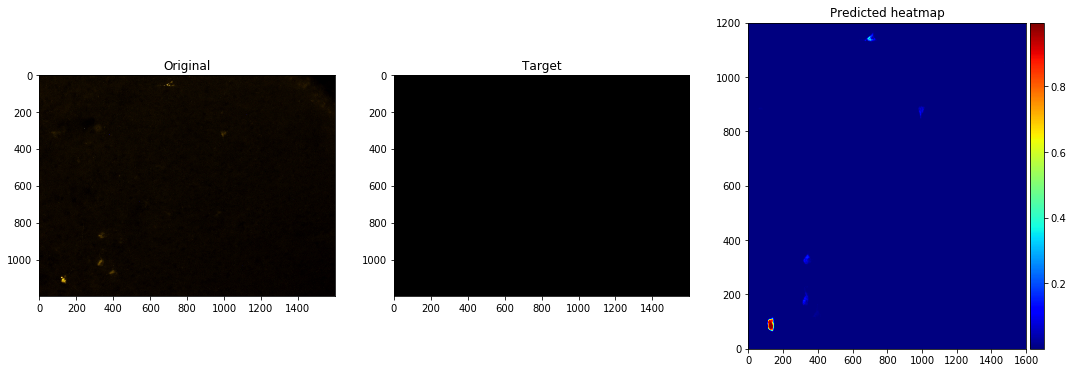

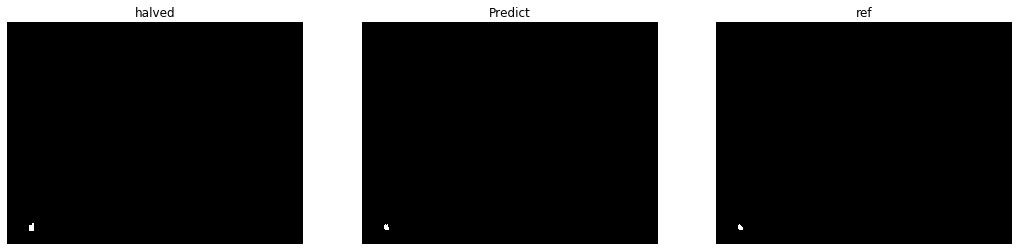

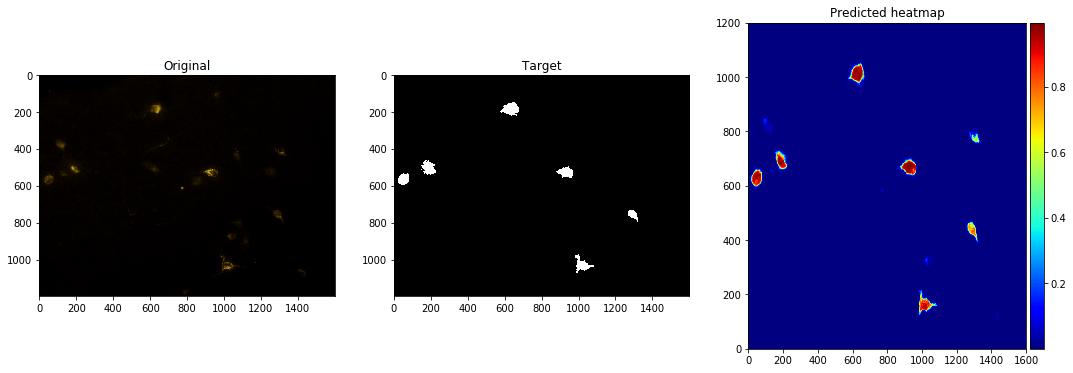

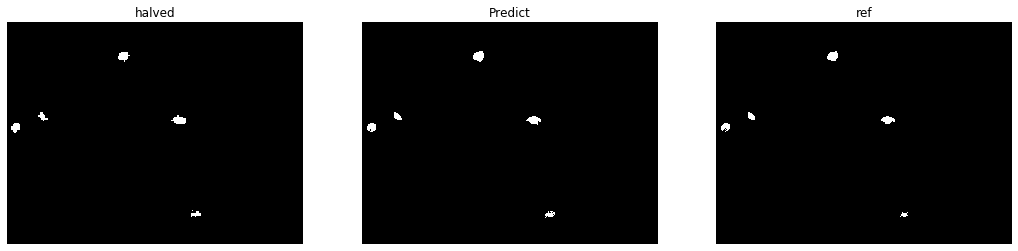

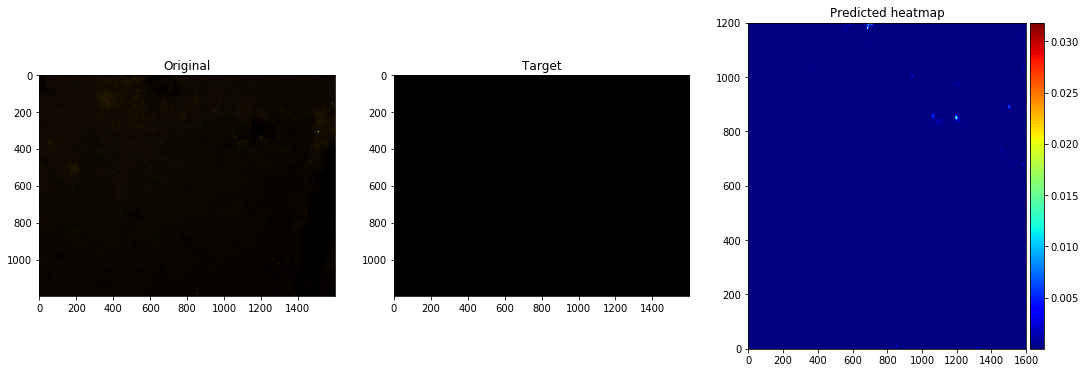

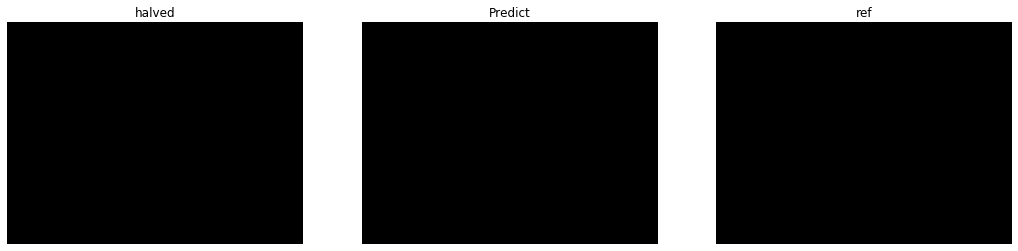

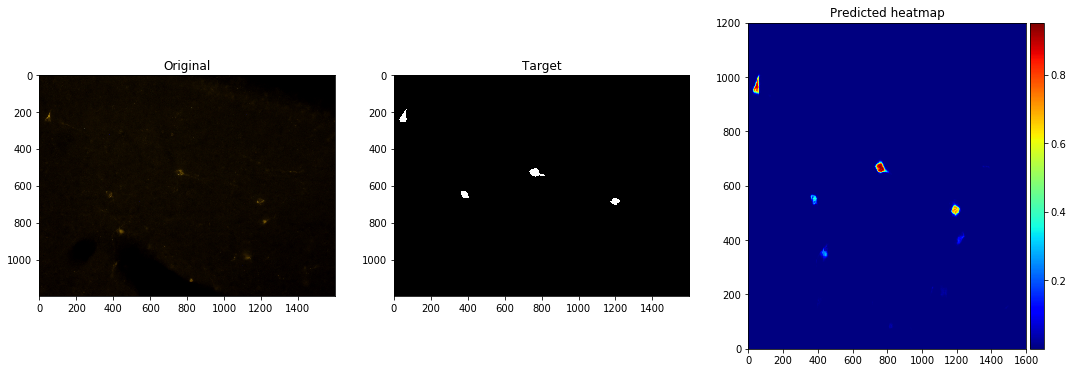

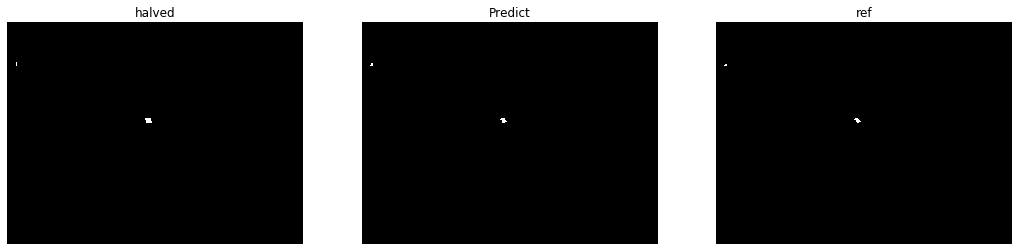

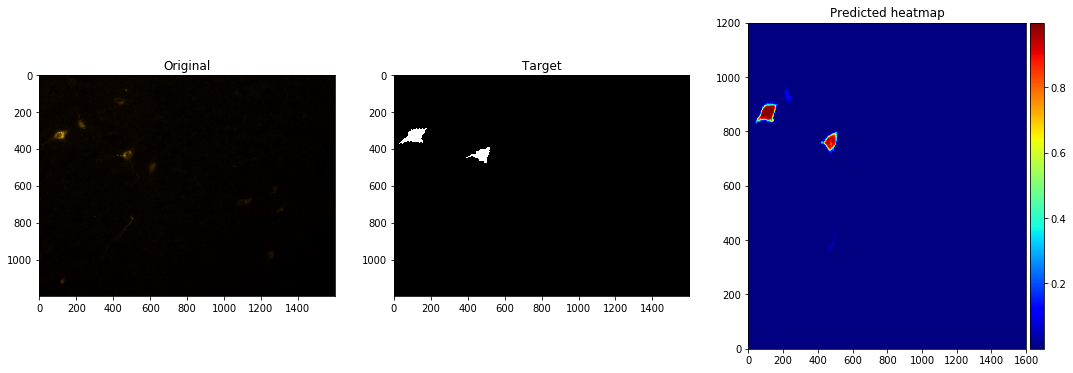

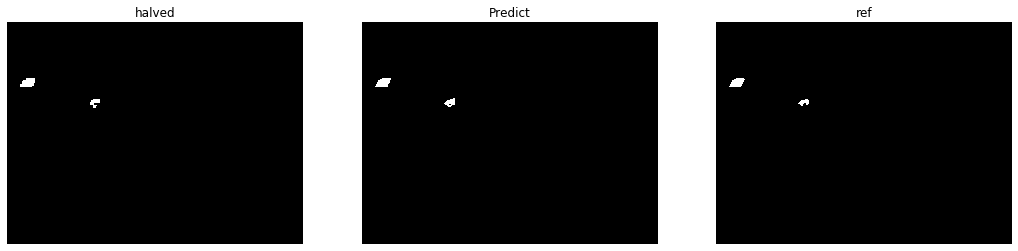

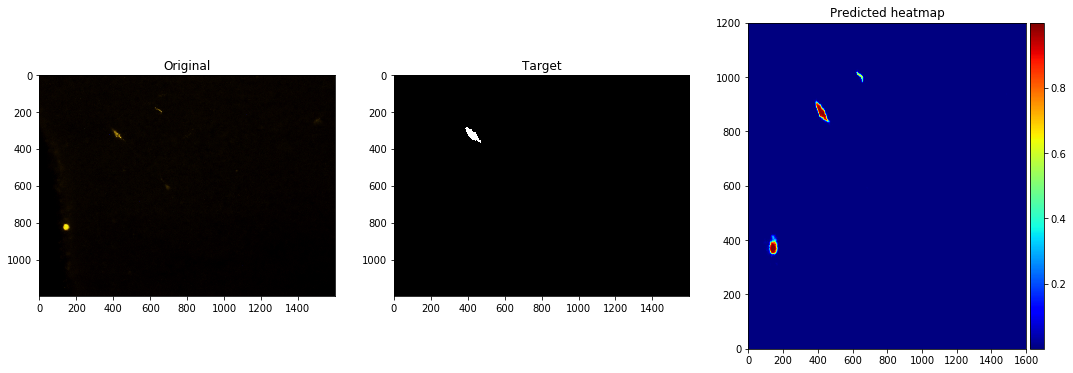

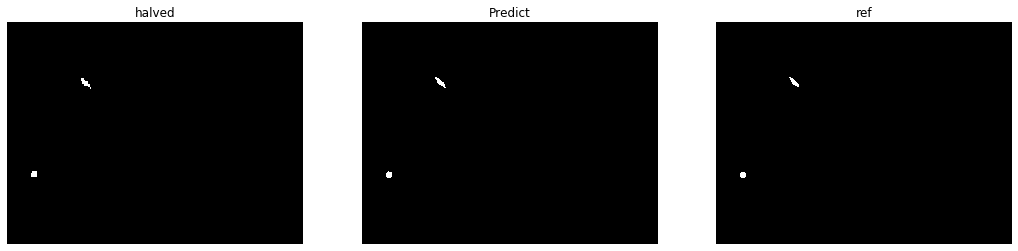

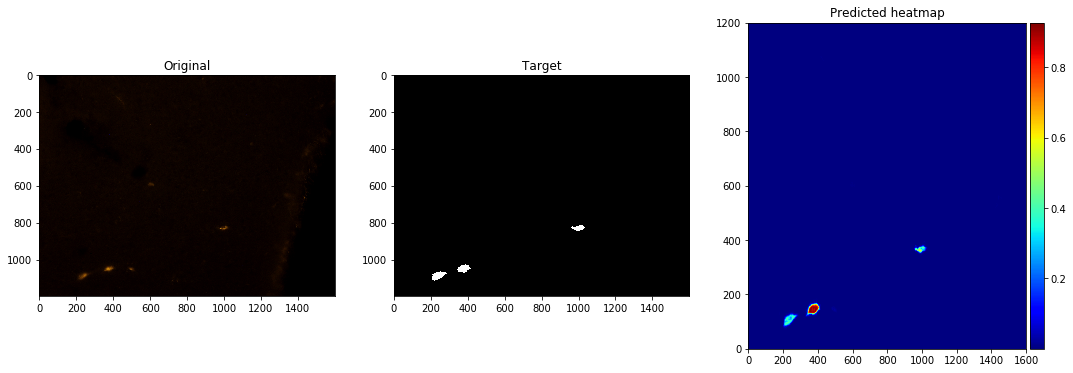

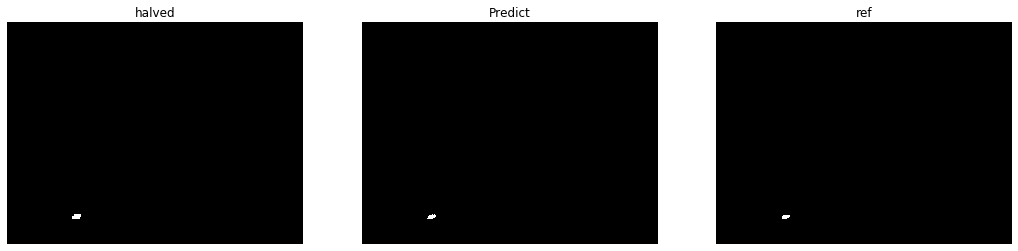

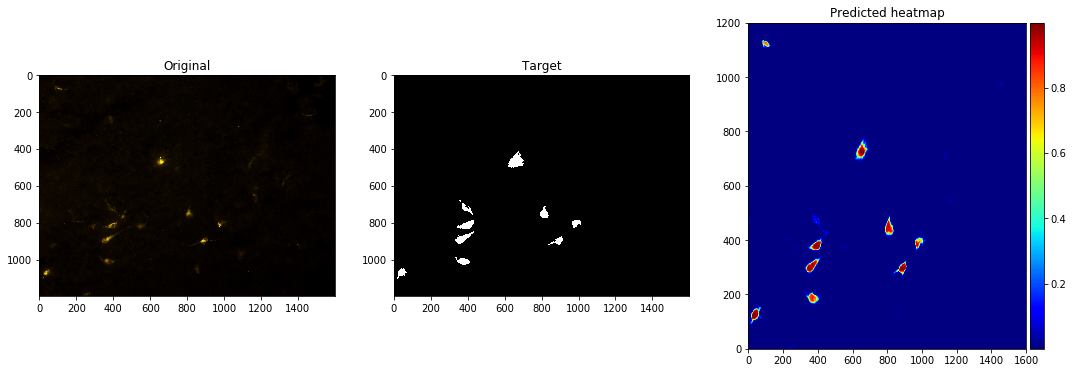

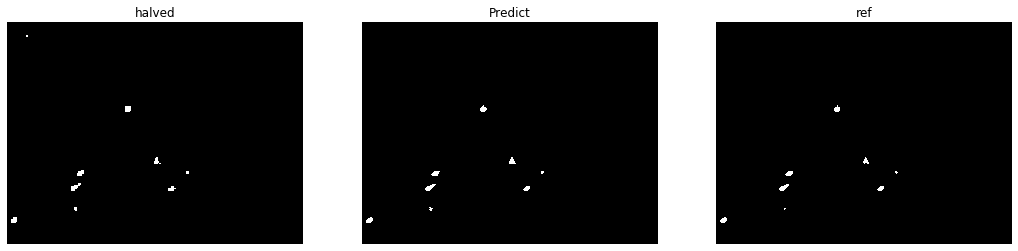

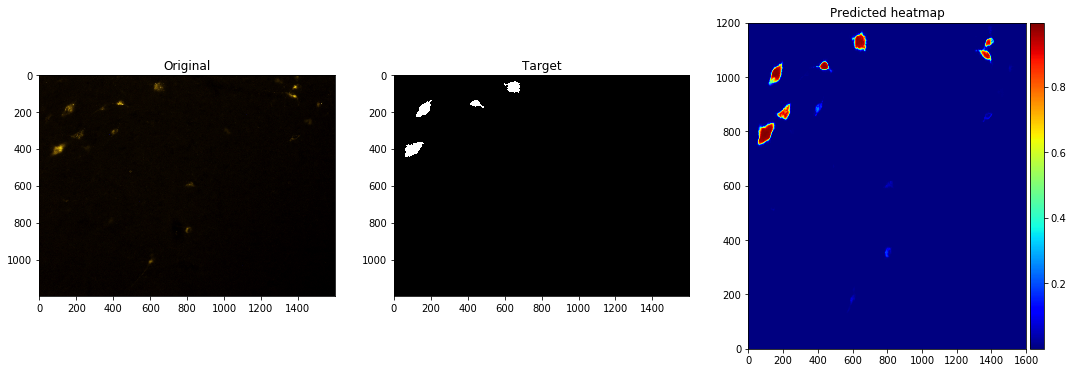

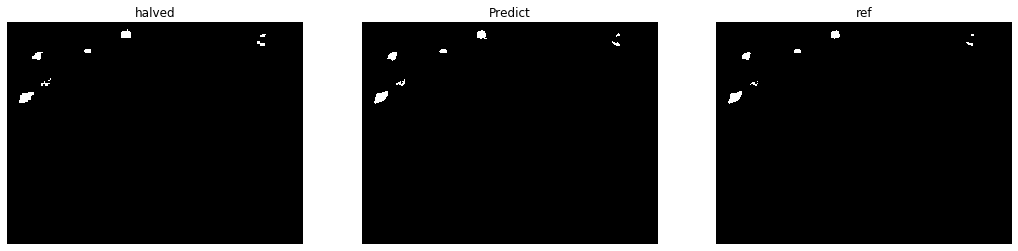

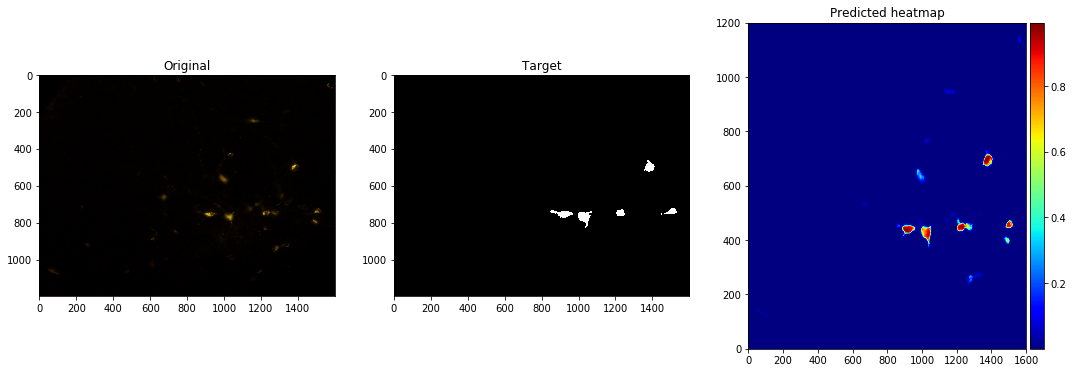

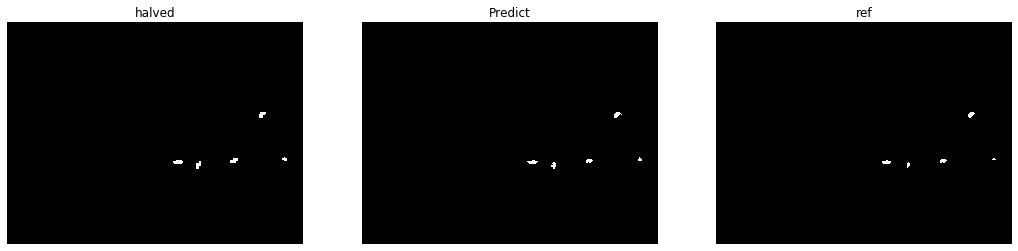

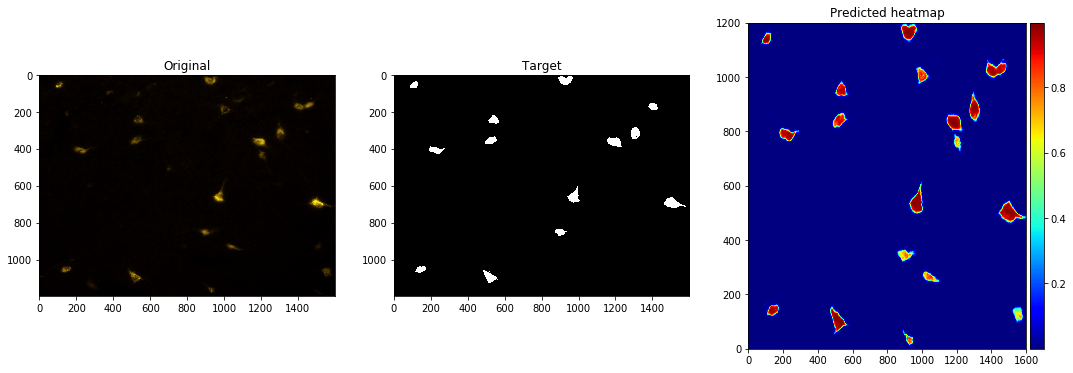

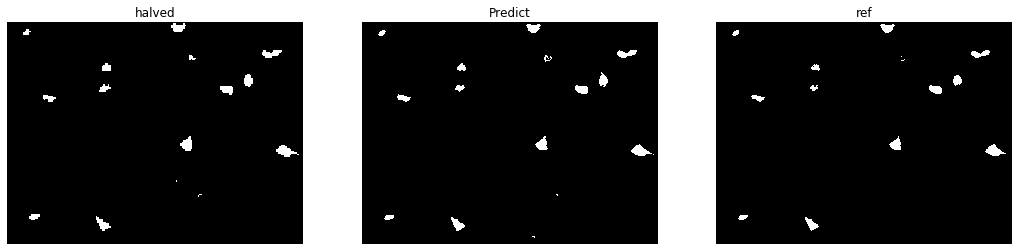

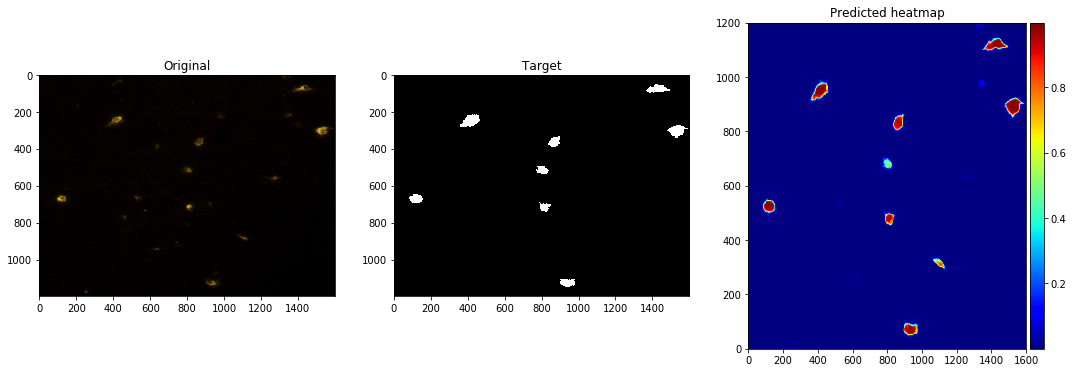

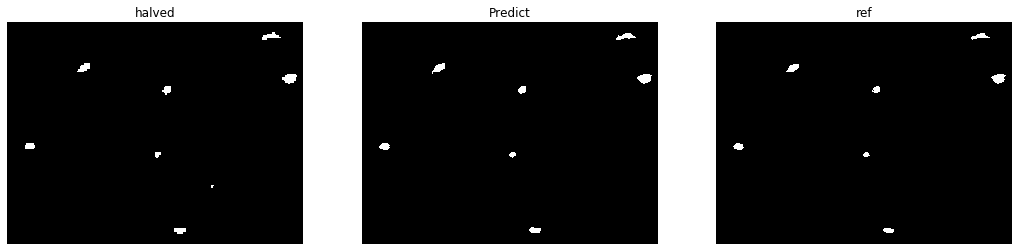

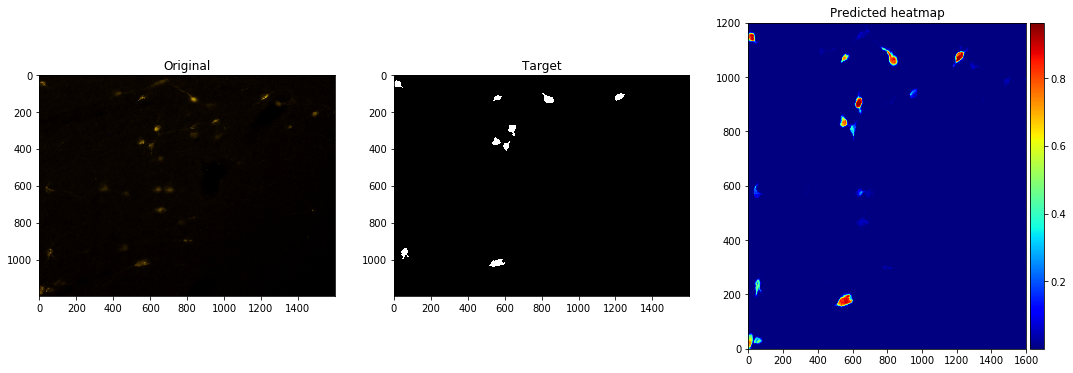

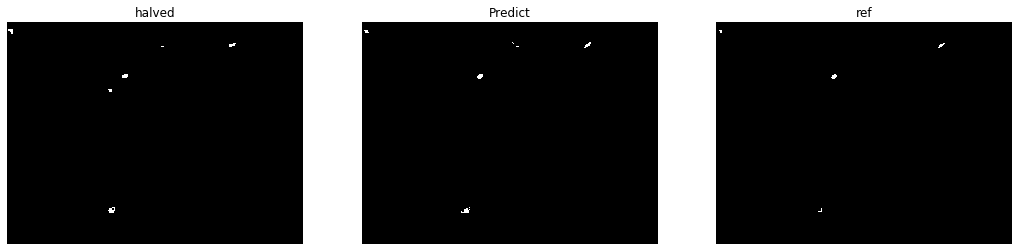

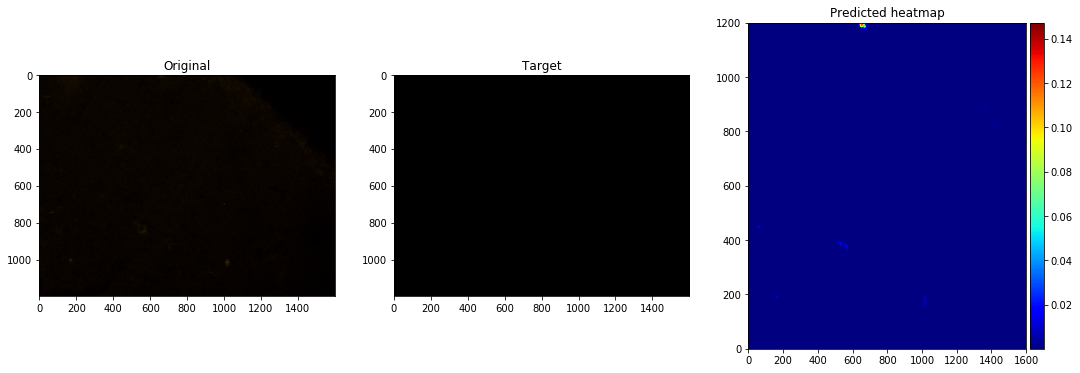

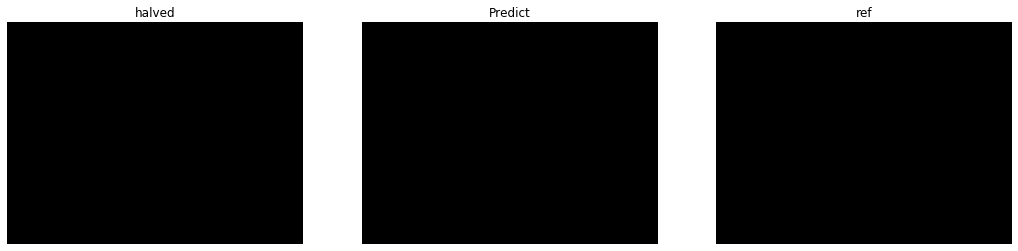

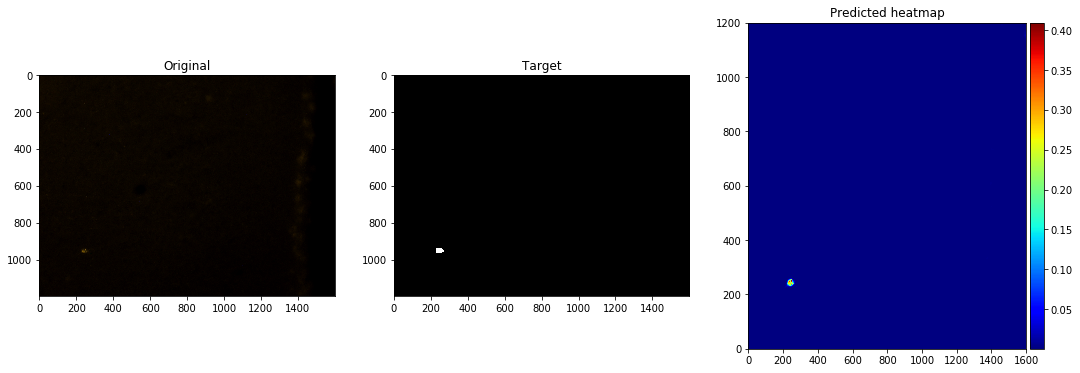

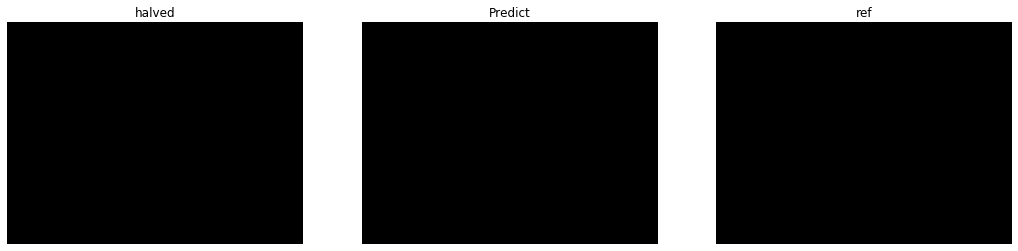

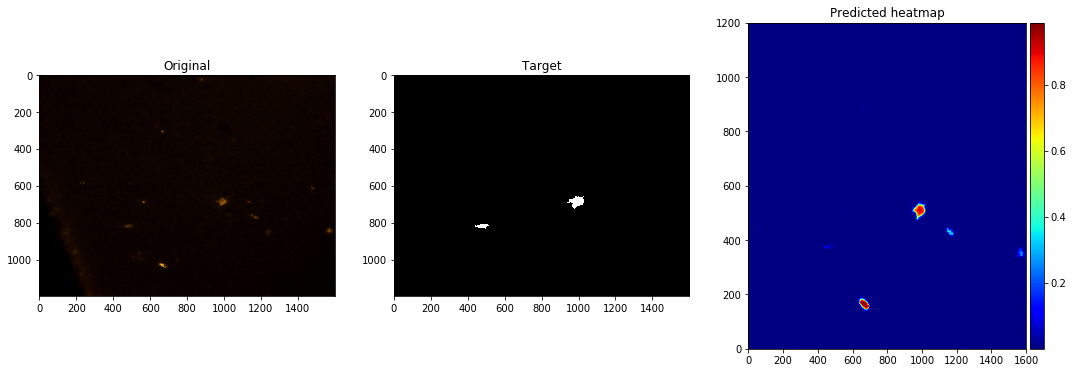

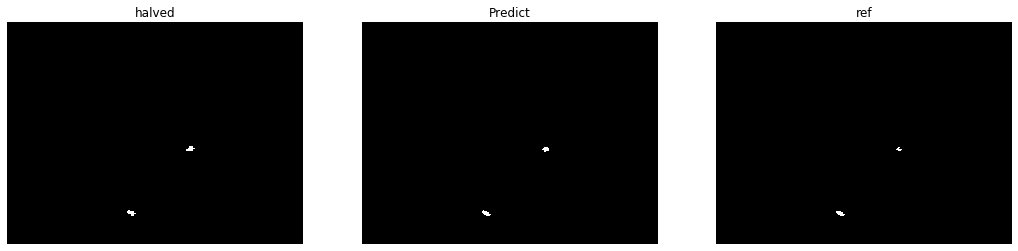

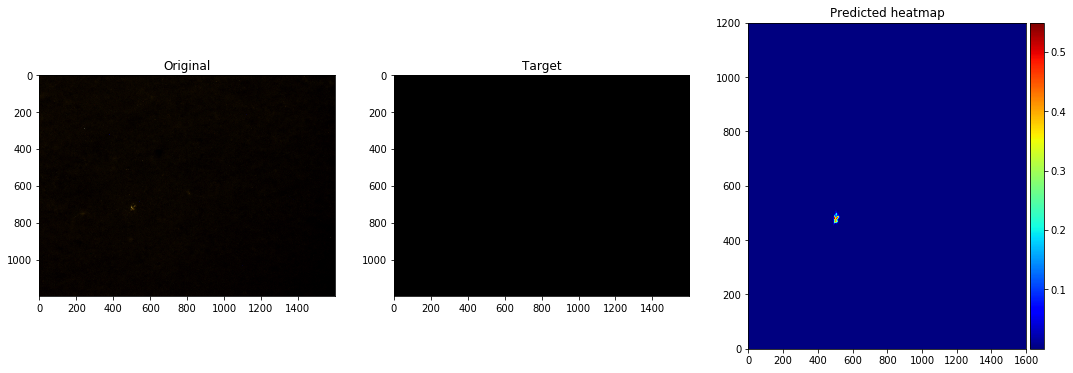

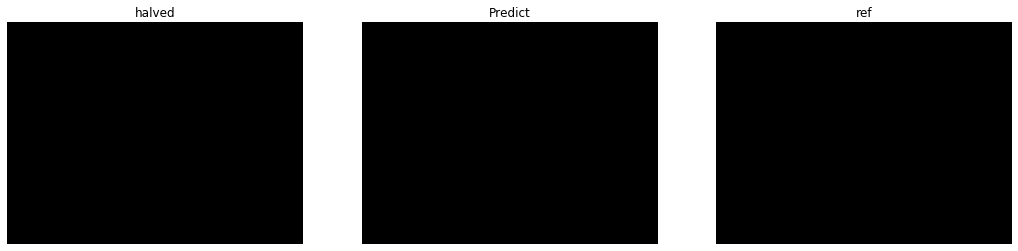

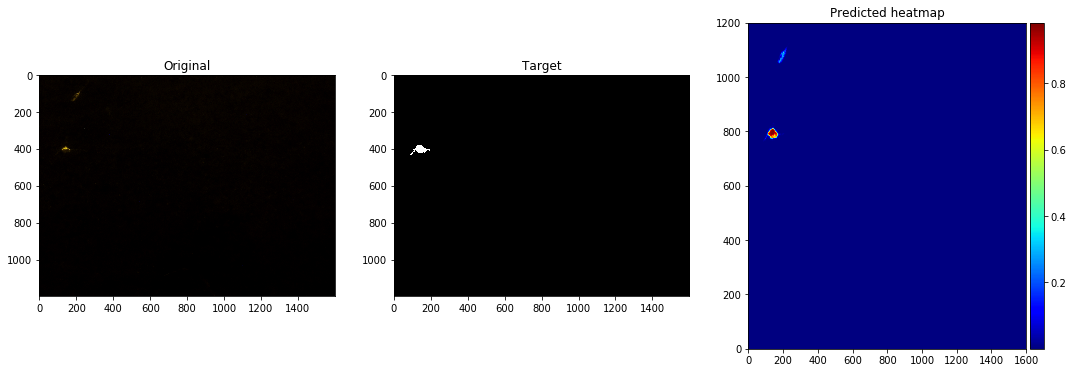

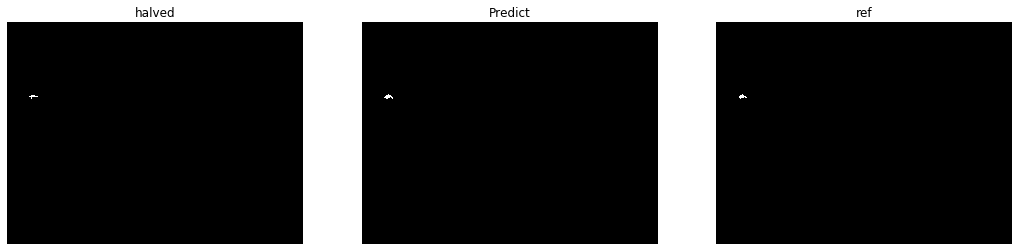

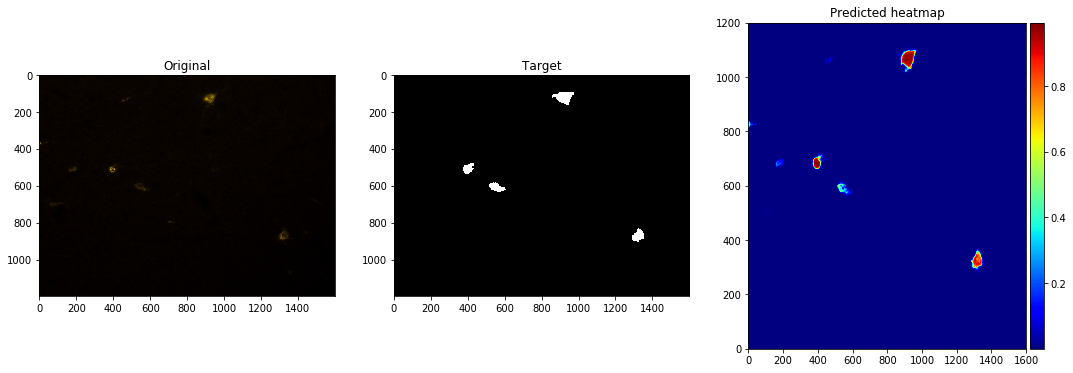

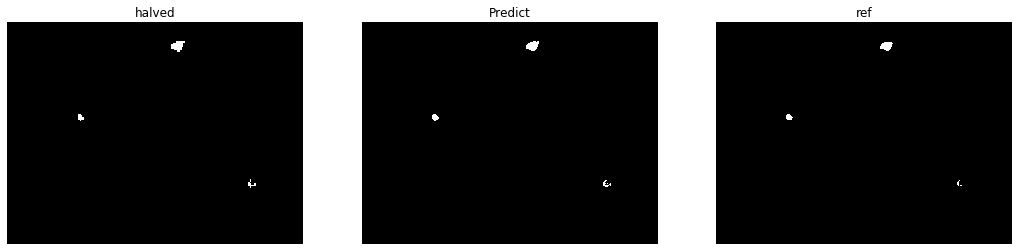

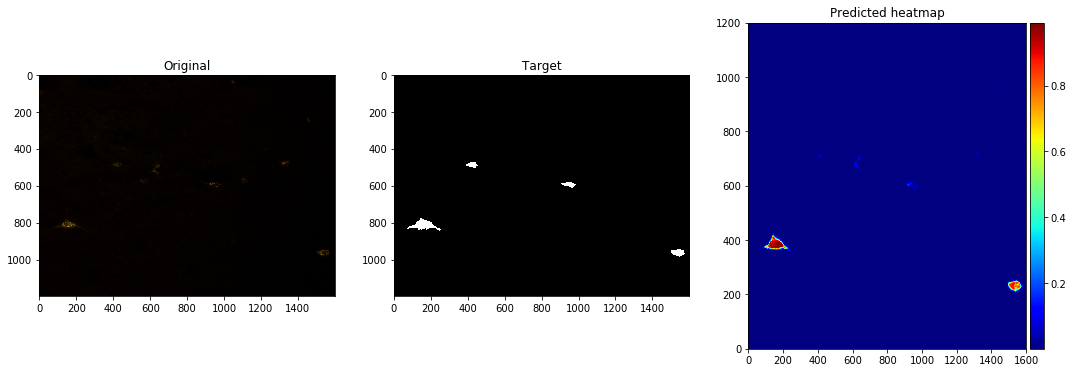

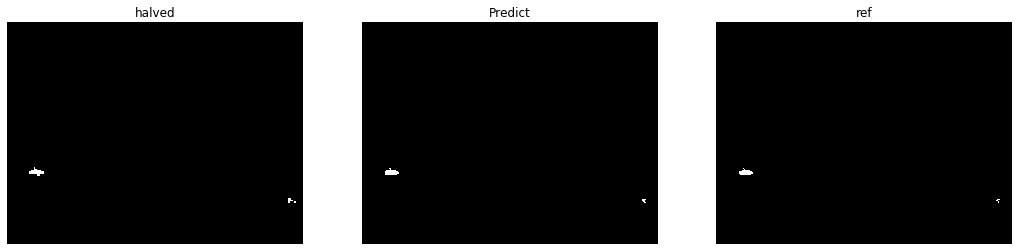

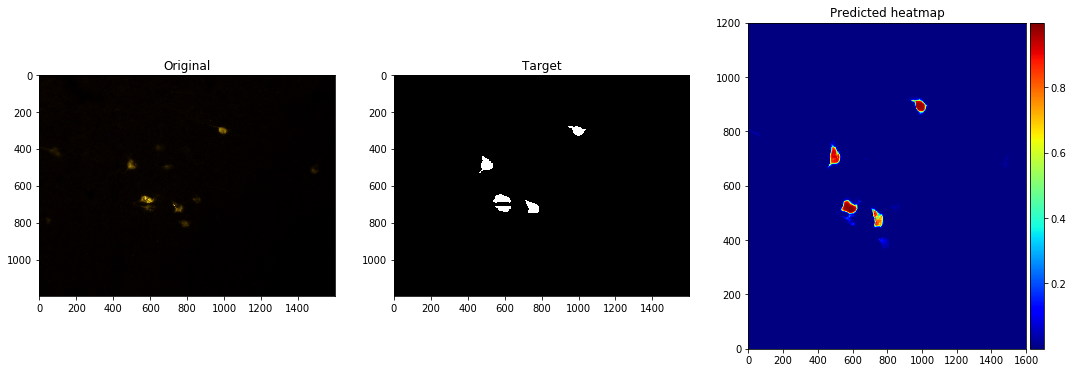

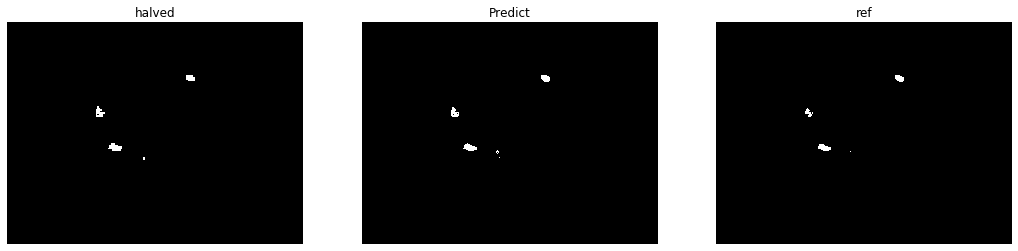

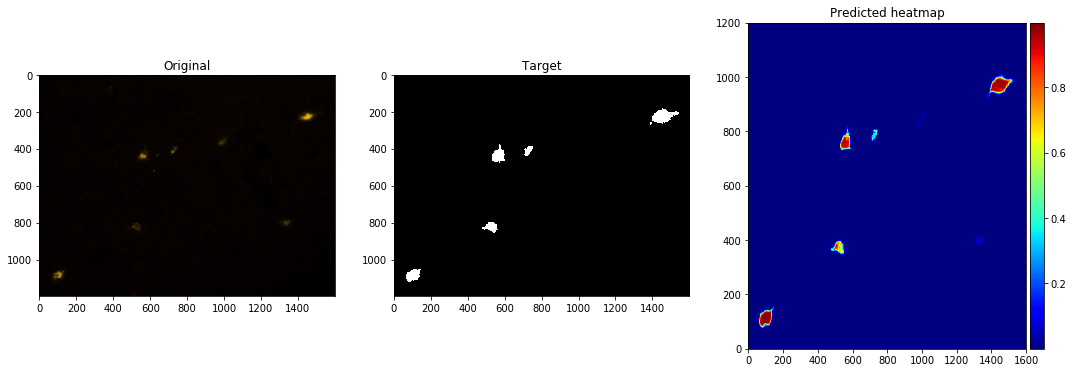

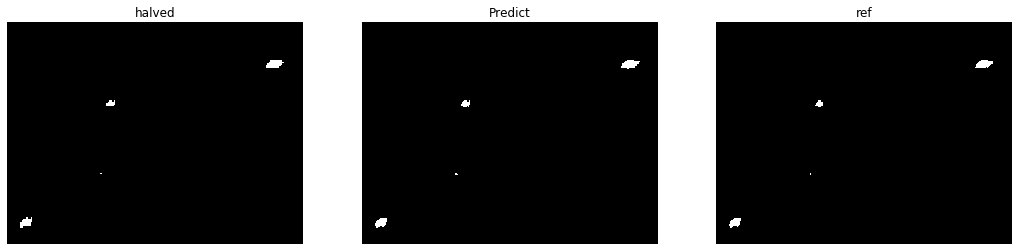

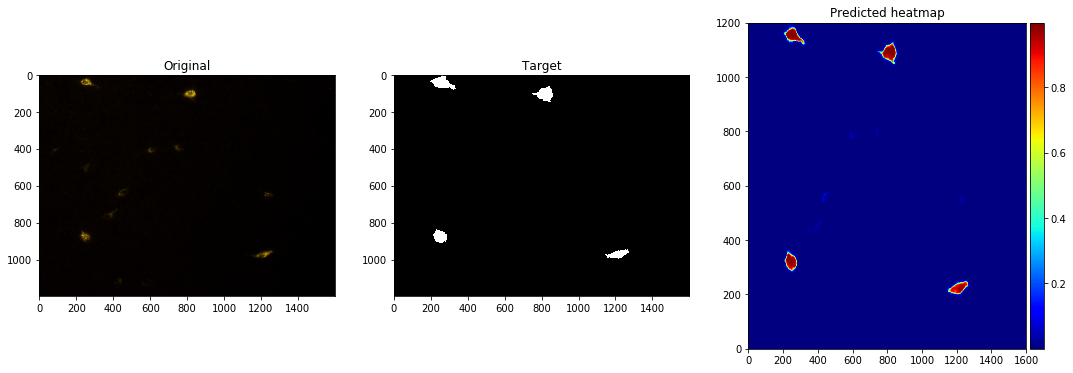

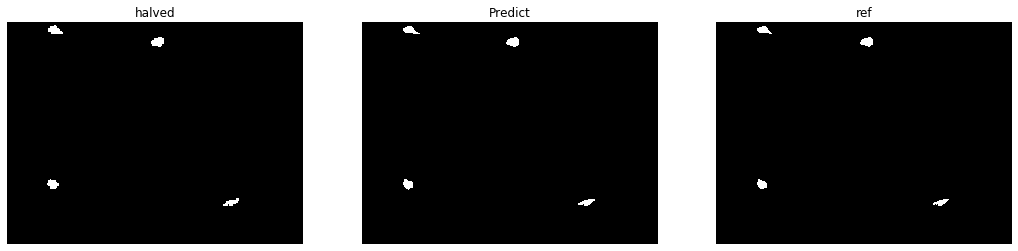

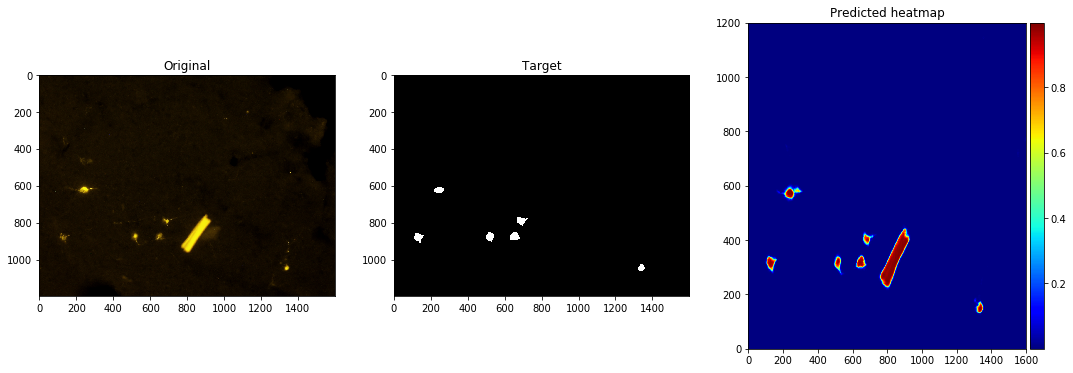

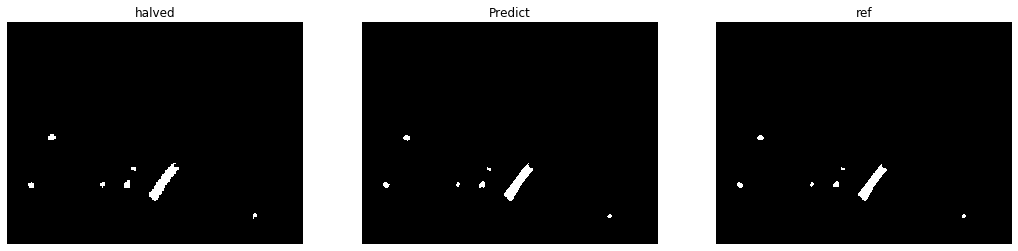

In [14]:
for i in range(len(Original)):
    
#     print(test_ids[i+start])
    original = Original[i]
    target = Target[i]
    heat_map = preds_map[1][i]
    halved = Predicted_halved[i]
    predicted = Predicted[i]
    ref = Predicted_ref[i]

        
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
       
    im = axes[0].imshow(original)
    axes[0].set_title('Original')
    
    im = axes[1].imshow(np.squeeze(target), cmap='gray')
    axes[1].set_title('Target')
    
    im = axes[2].pcolormesh(np.flipud(np.squeeze(heat_map)), cmap='jet')
    divider = make_axes_locatable(axes[2])
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)
    axes[2].set_title('Predicted heatmap') 
    
#     plt.subplot(2,3,1)
#     plt.title("Original")
#     plt.axis('off')
#     plt.imshow(original)
    
#     plt.subplot(2,3,2)
#     plt.title("Target")
#     plt.axis('off')
#     plt.imshow(np.squeeze(target), cmap = 'gray')
    
#     plt.subplot(2,3,3)
#     plt.title("pred_mat_output (not_refined)")
#     plt.axis('off')
#     plt.imshow(np.squeeze(heat_map),cmap='jet')    
    
        
    plt.figure(figsize=(18,12))
    
    plt.subplot(1,3,1)
    plt.title("halved")
    plt.axis('off')
    plt.imshow(np.squeeze(halved),cmap='gray')

    
    plt.subplot(1,3,2)
    plt.title("Predict")
    plt.axis('off')
    plt.imshow(np.squeeze(predicted),cmap='gray')
    
    plt.subplot(1,3,3)
    plt.title("ref")
    plt.axis('off')
    plt.imshow(np.squeeze(ref),cmap='gray')  
    
    plt.show()

In [ ]:
# def func(x):

#     greater = K.greater_equal(x,0.5) #will return boolean values
#     greater = K.cast(greater, dtype=K.floatx()) #will convert bool to 0 and 1    
#     return greater 


# model.add(Lamnda(func,output_shape=yourOtputShapeIfUsingTheano))